In [ ]:
import os
import json
from measures.utils import *
from measures.measures import *
import numpy as np
from sklearn.linear_model import LinearRegression
from datasets_folder.dataset import DatasetIMDB2, DatasetNLI2, Reuters, AAPD
import matplotlib.pyplot as plt


old_names_to_new = {
    "IBPs_ini":"IBP-AI",
    "IMPs_ini":"MP-AI",
    "randoms_ini":"RP-AI",

    "IBP-WRs":"IIBP-WR",
    "IBPs":"IIBP",
    

    "IMP-WRs":"IMP-WR",
    "IMPs":"IMP",
    

    "randoms":"IRP"
    
}

def generate_ie_graphs(path, n_initializations=30):

    to_plot = []

    thres = ["0","20","50","70","90","99"]


    width = 10
    height = 8

    colors={"20":'#ff595e',
            "50":'#ffca3a',
            "70":'#8ac926',
            "90":'#1982c4',
            "99":'#6a4c93'}
    


    n_bins = 20
    y = [i+1 for i in range(n_bins)]
    
    X = np.array([[i] for i in range(20)])

    
    
    n_ini = n_initializations-1
    dirs = []
    for file in os.listdir(path):
        d = os.path.join(path, file)
        if os.path.isdir(d):
            dirs.append(file)
    
    final_dirs = {}
    for exp in dirs:
        if "orig" not in exp and os.path.isfile(path+"/"+exp+"/"+str(n_ini)+"_measures.json"):
            
            #print(path+"/"+exp+"/0_measures.json")
            f = open(path+"/"+exp+"/0_measures.json")
            data = json.load(f)

            dic_name = exp.split("_")[:3]
            dic_name = ("_").join(dic_name)
            if dic_name in final_dirs:
                final_dirs[dic_name].append((exp, len(data["accuracy"][0])-1))
            else:
                final_dirs[dic_name] = [(exp, len(data["accuracy"][0])-1)]
            f.close()

    preds_old, preds_dense = None, None
    
    print(final_dirs)
    for key in final_dirs:
        if True:
            multilabel = False

            if "IMDB" in key:
                labels_n = [("pos",1),("neg",0)]
                training_set = DatasetIMDB2("", labels_n)
                training_set.load_set("train", vec_max_len=5)

            elif "SNLI" in key:
                labels_n = [("entailment",0),("neutral",1),("contradiction",2)]
                training_set = DatasetNLI2("", labels_n)
                training_set.load_set("train",  vec_max_len=200)

            elif "Reuters" in key:
                multilabel=True
                lines = []
                with open('data/Reuters/reuters_labels.txt') as f:
                    lines = f.read().splitlines()
                labels_n = [(lines[i], i) for i in range(len(lines))]

                training_set = Reuters("0", labels_n)
                training_set.load_set("train", vec_max_len=3)

            elif "AAPD" in key:
                multilabel=True
                labels_n = [0]*54
                training_set = AAPD("", "")
                training_set.load_set("train", vec_max_len=3)
                

            labels = training_set.labels
            labels = torch.tensor(labels)


            to_track = {"dataset":[],"model":[],"pruning algo":[],
                "0":[], "20":[], "50":[],"70":[], "90":[],"99":[]}

            num = 0
            tn = 0

            for n in final_dirs[key]:
                if "NoPruning" in n[0]:
                    num=n[1]
                    tn = str(round(0.6*(n[1]+1)))

            preds_old = retrieve_predictions(path+"/"+key+"_NoPruning_0/","_epoch_"+tn+"_train",n_initializations, tn)
            preds_dense = retrieve_predictions(path+"/"+key+"_NoPruning_0/","_epoch_"+str(num)+"_train",n_initializations)
            if multilabel:
                preds_dense = apply_sig(preds_dense)
            rank, indexes = get_indexes(preds_old, labels, multilabel=multilabel)

            densep = None
            if not multilabel:
                densep = retrieve_pred(preds_dense, len(labels_n))
            

            groups = {}
            
            pairs = {}

            for i, (name, num) in enumerate(final_dirs[key]):
                tmp_n = name[:-3]
                print(tmp_n)
                if tmp_n in groups:
                    groups[tmp_n].append((name, num))
                else:
                    groups[tmp_n]=[(name,num)]
                    
                if "NoPruning" not in name and "random-WRs" not in name:
                    dic_name = name.split("_")

                    algo = dic_name[3]
                    if dic_name[-2]=="ini":
                        algo+="_ini"

                    to_track["dataset"].append(dic_name[0])
                    to_track["model"].append(dic_name[2])
                    to_track["pruning algo"].append(algo)

                    pairs[name]=i

                    for t in thres:
                        to_track[t].append(None)


                    preds=retrieve_predictions(path+"/"+name+"/","_epoch_"+str(num)+"_train",n_initializations)





                    pies_ind = None
                    if multilabel:
                        preds = apply_sig(preds)

                        ts = []
                        td = []

                        sparse = path+"/"+name+"/"
                        dense = path+"/"+key+"_NoPruning_0/"


                        for i in range(n_initializations):
                            f = open(dense+str(i)+"_measures.json")
                            data = json.load(f)
                            td.append(data["threshold"][-1])

                            f = open(sparse+str(i)+"_measures.json")
                            data = json.load(f)
                            ts.append(data["threshold"][-1])

                        pies = retrieve_pies(preds_dense, preds, thresholds=(td, ts))

                        pies_ind = get_distinct_pies(pies)

                    else:

                        sparsep = retrieve_pred(preds, len(labels_n))

                        pies = retrieve_pies(densep, sparsep, len(labels_n))
                        
                        pies_ind = np.where(pies)[0]
                    


                    bins = [0]*n_bins

                    ranks = list(rank)
                    ranks = {x:i for i,x in enumerate(ranks)}

                    for pie in pies_ind:
                        t = ranks[pie]
                        val = -1
                        for i in range(n_bins):
                            val = i
                            #print(pie)
                            if t>= indexes[i][0] and t<= indexes[i][-1]:
                                break
                        bins[val]+=1
                    

                    x = bins

                    for a in range(n_bins):
                        x[a] = x[a]/len(pies_ind)


                    to_track[dic_name[-1]][-1] = x
                else:

                    to_track["dataset"].append(dic_name[0])
                    to_track["model"].append(dic_name[2])
                    to_track["pruning algo"].append(algo)

                    pairs[name]=i

                    for t in thres:
                        to_track[t].append(None)

                
            for group in groups:
                preds_sparse = []
                legend = []

                
                name = ""
                for keyn in old_names_to_new:
                    if keyn in group:
                        name = old_names_to_new[keyn]
                        break

                tmp_names = group.split("_")

                info = {}

                
                plt.figure(figsize=(width, height))
                plt.xlim(1, 20)
                plt.yticks(fontsize=13)
                plt.xticks([1, 5, 10, 15, 20],["1", "5", "10", "15", "20"], fontsize=17)
                plt.xlabel('Binned data points', fontsize=20)
                plt.ylabel('% PIEs', fontsize=20)

                plt.title(tmp_names[0]+" "+tmp_names[2]+" "+name, fontsize=30)
                info["title"] = tmp_names[0]+" "+tmp_names[2]+" "+name

                x = [i+1 for i in range(20)]

                

                info['to_plot']={}

                for (name, num) in groups[group]:
                    if "NoPruning" not in name and "random-WRs" not in name: 
                        name_config = name.split("_")
                        pt = name_config[-1]

                        plt.step(x, to_track[pt][pairs[name]], alpha=0.7, color=colors[pt], where='mid', linewidth=2) 
                        info['to_plot'][pt]=(to_track[pt][pairs[name]], colors[pt])
                        legend.append(name)
                
                
                
                labels = list(colors.keys())

                algo = name_config[3]
                if name_config[-2]=="ini":
                    algo+="_ini"

                info["filename"]='Images/anal4/'+tmp_names[0]+"_"+tmp_names[2]+"/"+group+'.pdf'
                to_plot.append(info)
                print(info)
                
                
                if not os.path.isdir('Images/anal4/'+tmp_names[0]+"_"+tmp_names[2]):
                    os.makedirs('Images/anal4/'+tmp_names[0]+"_"+tmp_names[2])
                plt.savefig('Images/anal4/'+tmp_names[0]+"_"+tmp_names[2]+"/"+group+'.pdf', dpi=400, transparent=True, pad_inches=0.02)
            

    return (to_track, final_dirs), to_plot

res, info = generate_ie_graphs("./results/")

json_object = json.dumps(info, indent=4)
with open("partial_results_PIES_influential_examples.json", "w") as outfile:
	outfile.write(json_object)

[{'title': 'AAPD BERT IIBP-WR', 'to_plot': {'20': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0005063291139240507, 0.0006751054852320675, 0.00033755274261603374, 0.001350210970464135, 0.005063291139240506, 0.01350210970464135, 0.017383966244725737, 0.03814345991561181, 0.054177215189873416, 0.09113924050632911, 0.11206751054852321, 0.19476793248945148, 0.20270042194092827, 0.2681856540084388], '#ff595e'], '50': [[0.0, 0.0, 0.00015383432043688947, 0.0016152603645873394, 0.0017690946850242289, 0.0021536804861164525, 0.0046919467733251286, 0.00715329590031536, 0.009537727867087148, 0.020998384739635414, 0.030920698407814782, 0.0386893315898777, 0.0489962310591493, 0.06130297669410045, 0.07622490577647874, 0.10206907160987616, 0.12691331436043382, 0.15737250980693793, 0.1416814091223752, 0.16775632643642796], '#ffca3a'], '70': [[4.899799108236562e-05, 0.0003429859375765594, 0.0026458915184477435, 0.00793767455534323, 0.005242785045813121, 0.007545690626684306, 0.012690479690332697, 0.021314126120829

C:\Users\pzs162\AppData\Local\Temp\ipykernel_1336\886907811.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(width, height))


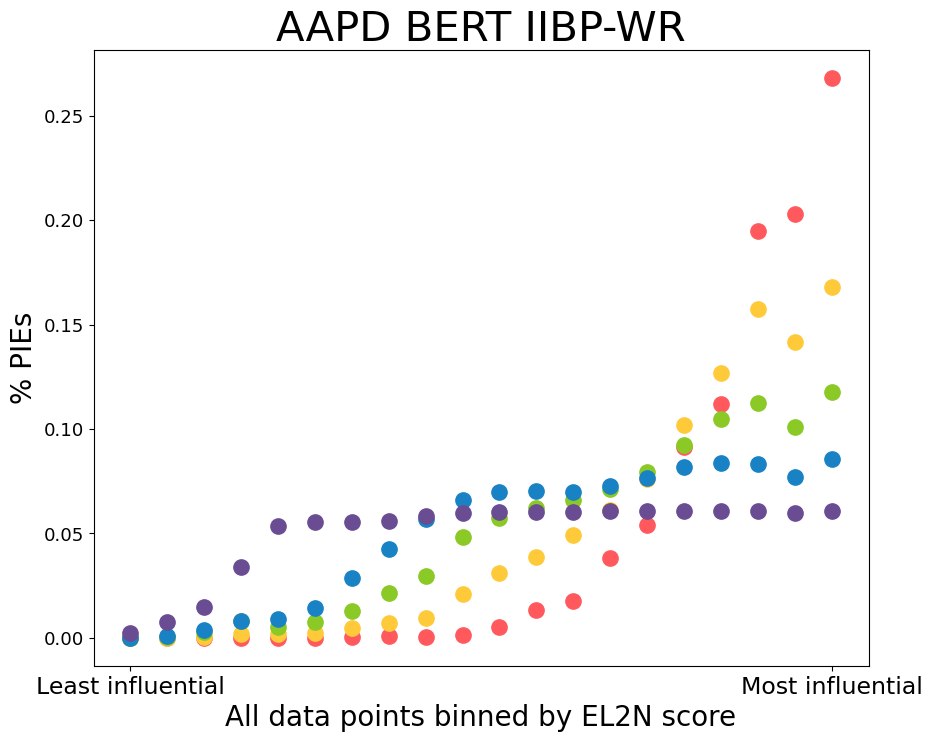

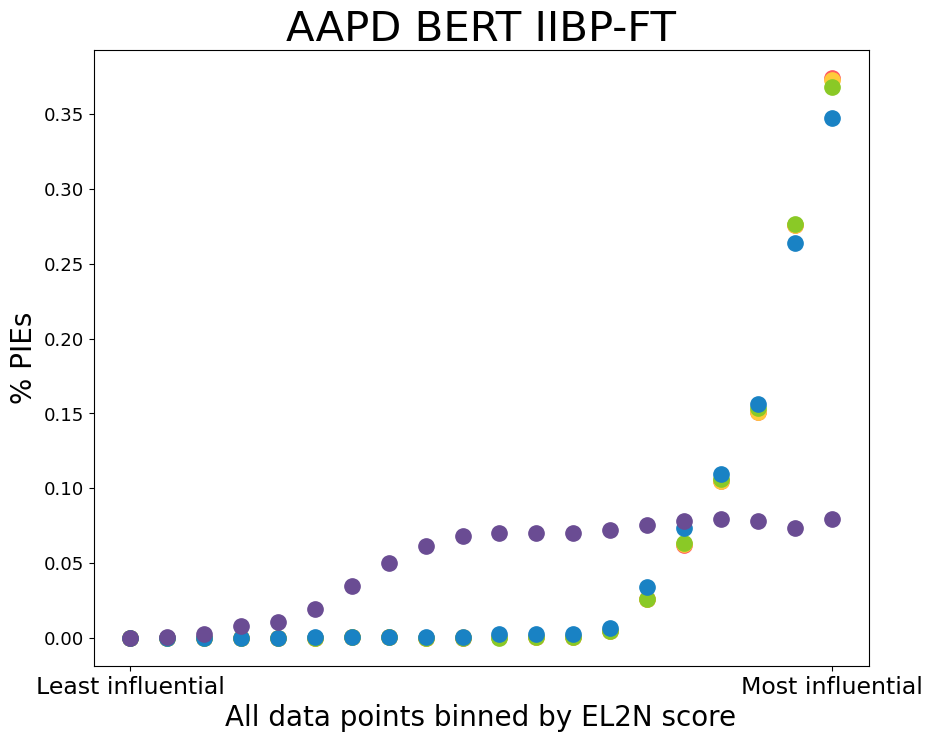

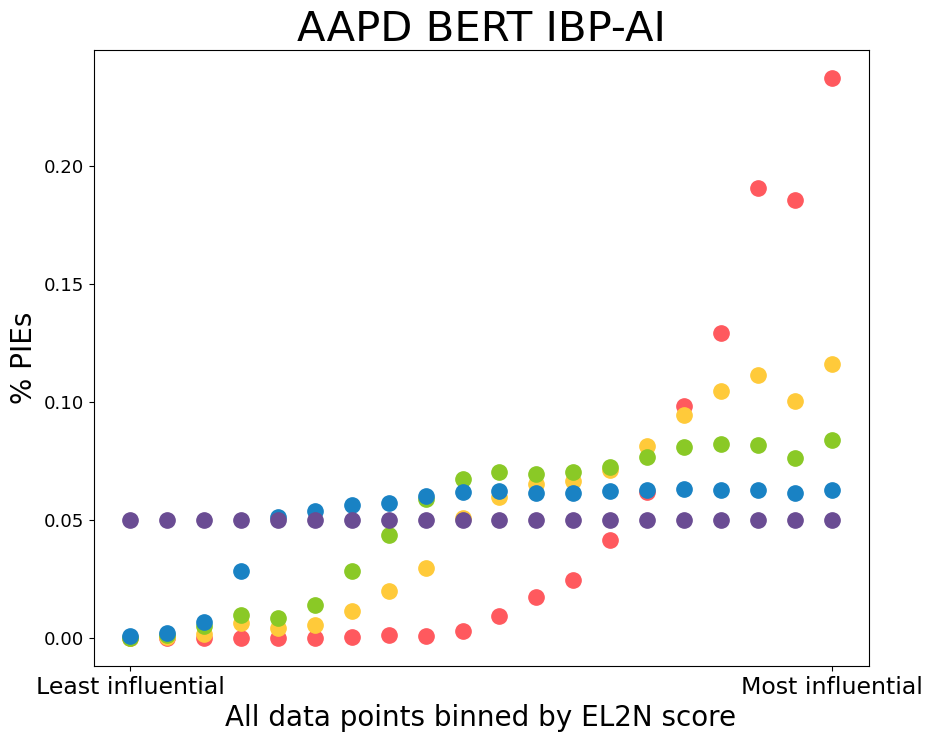

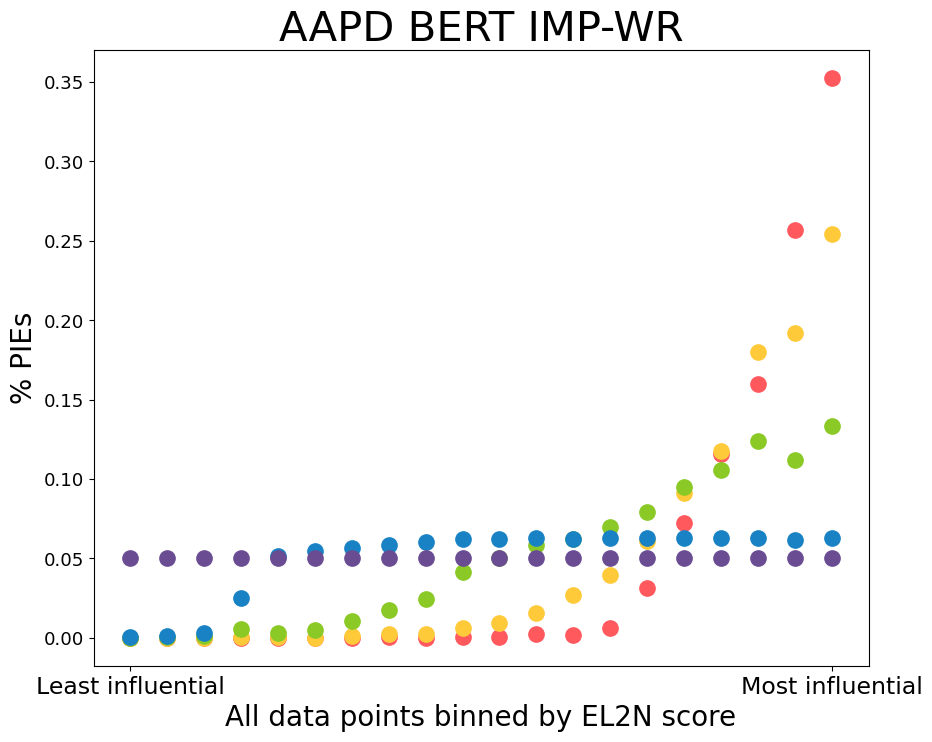

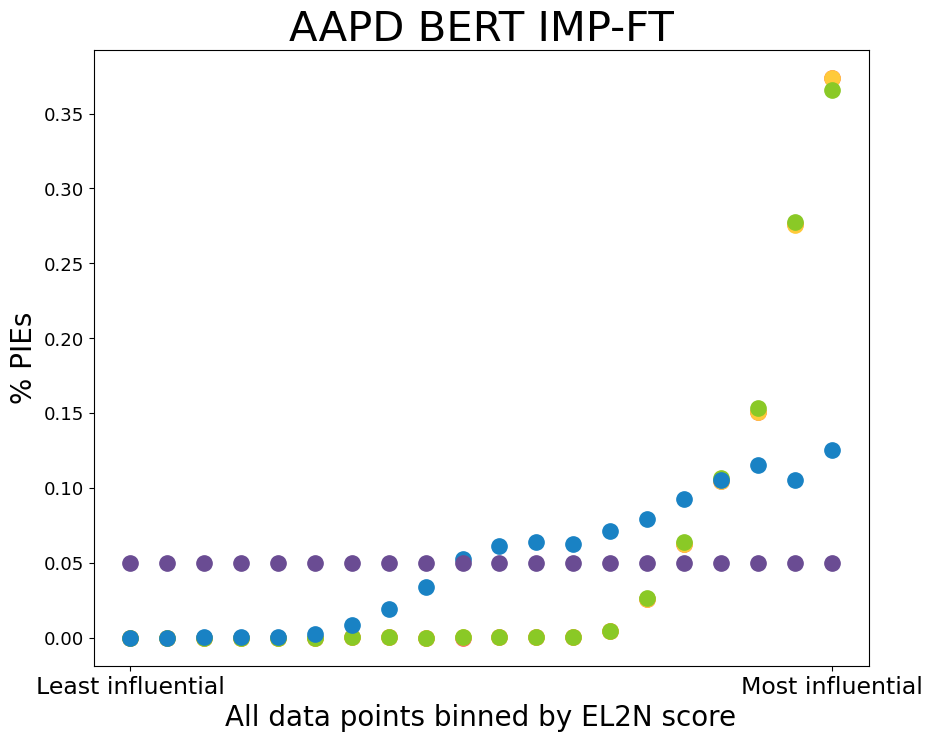

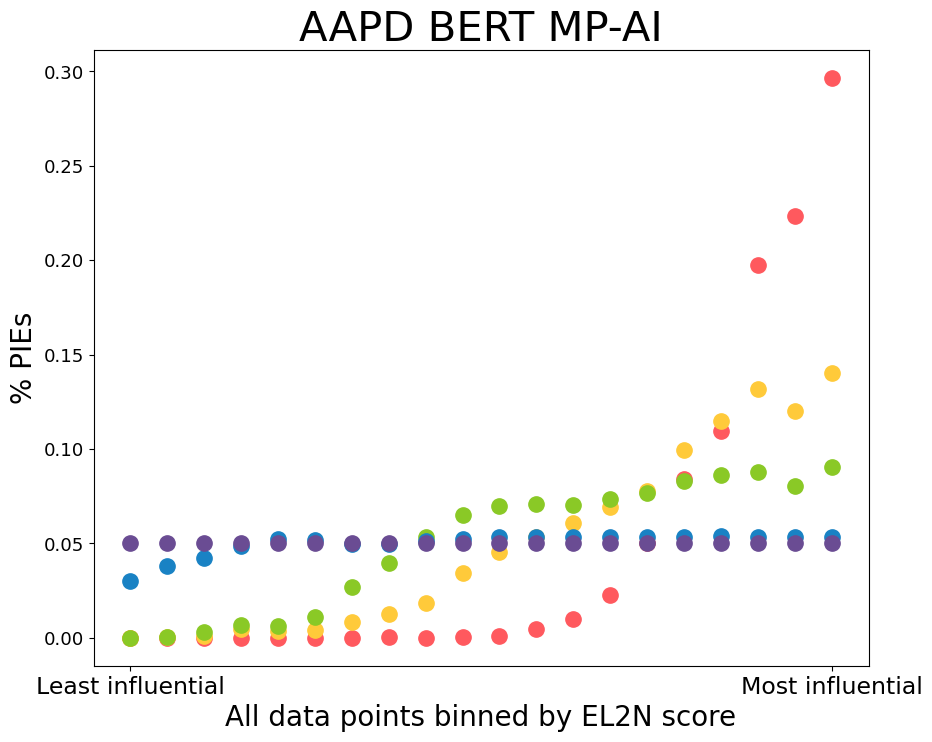

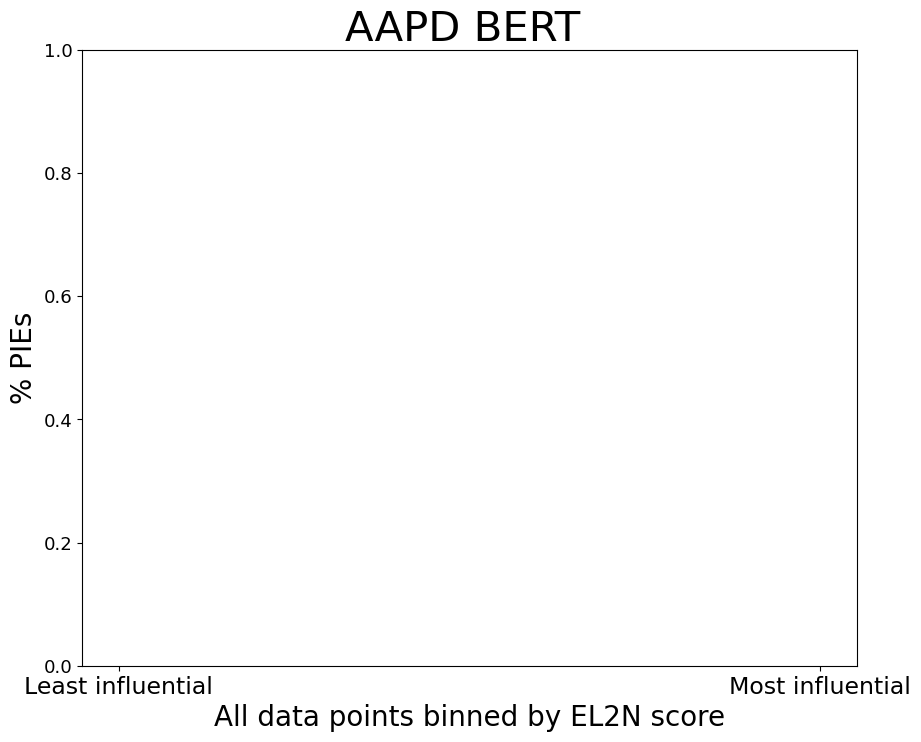

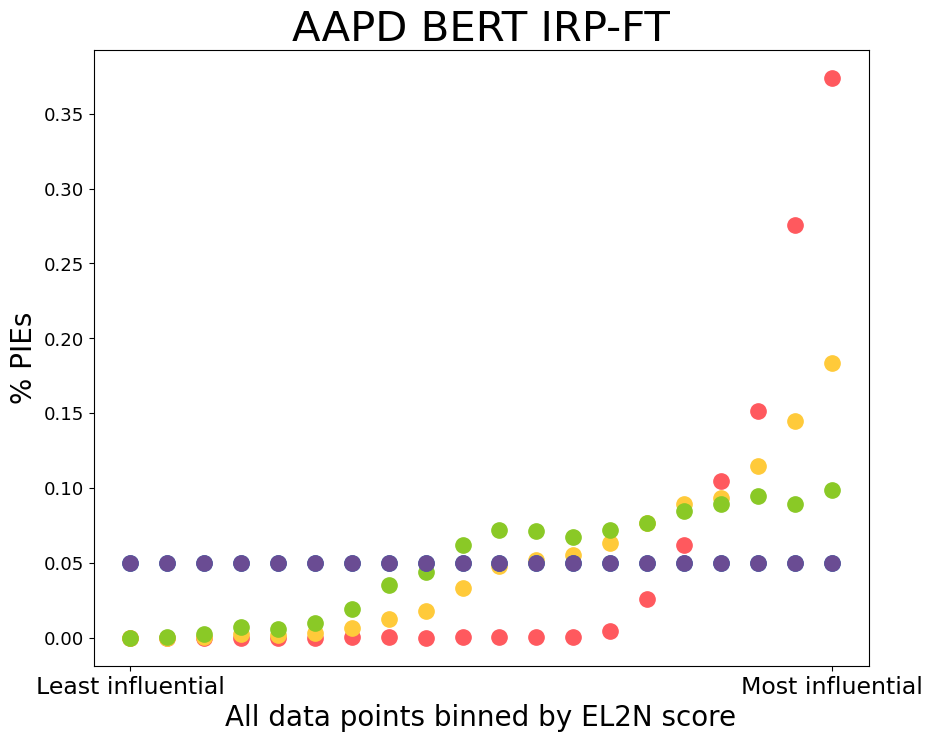

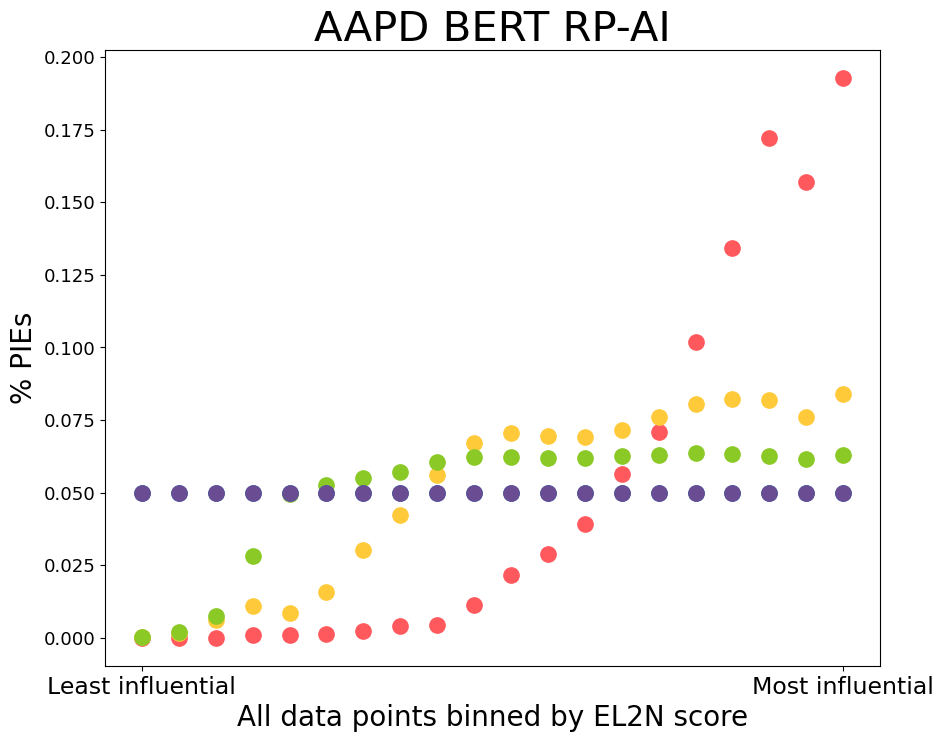

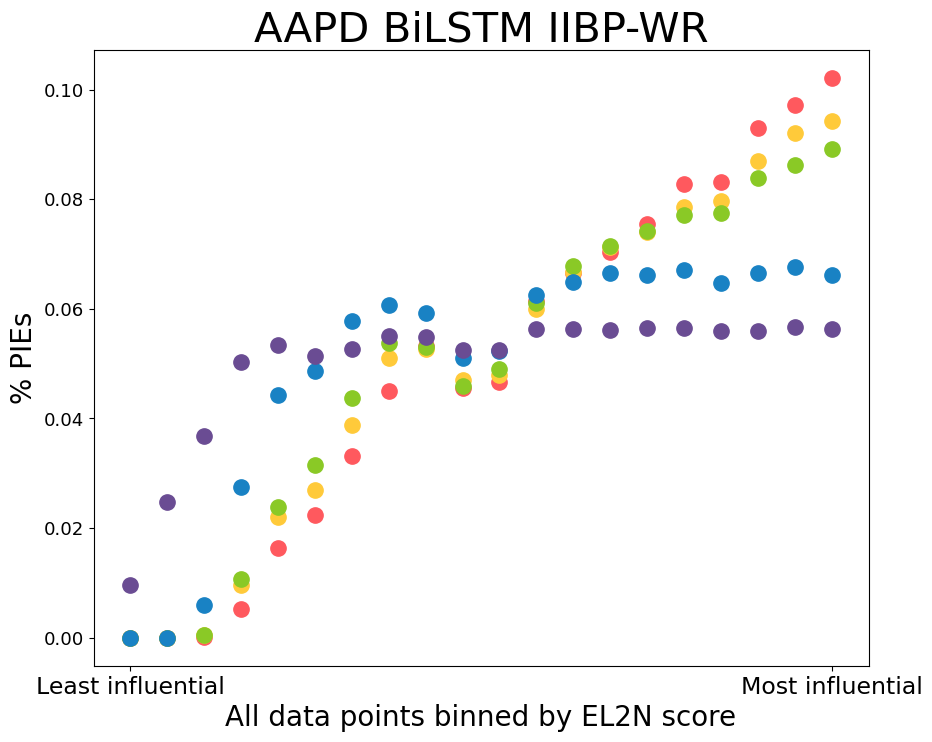

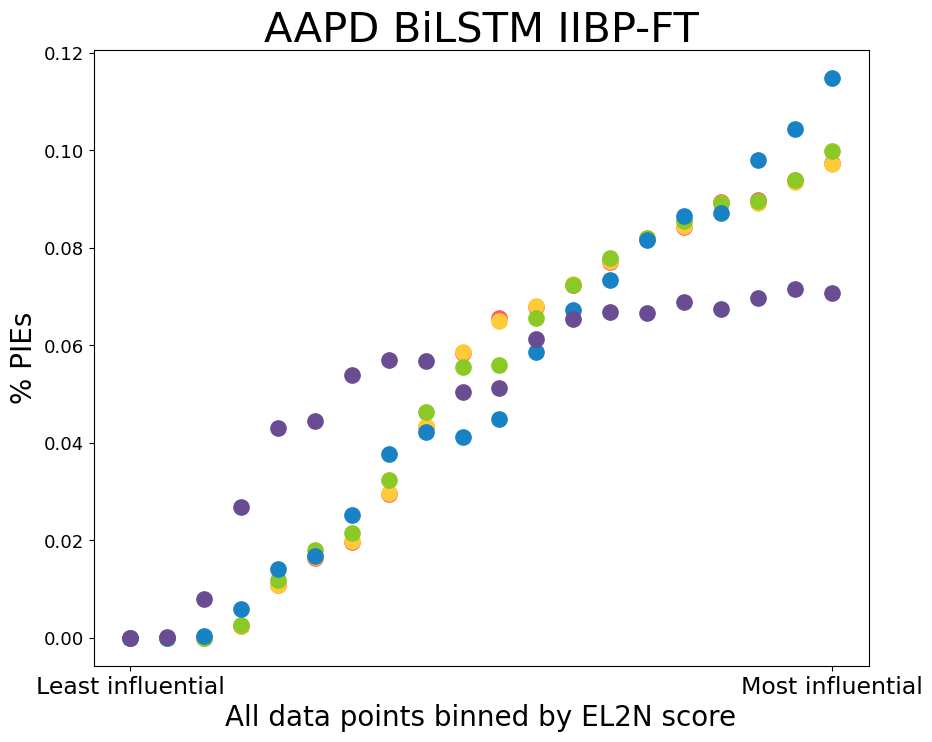

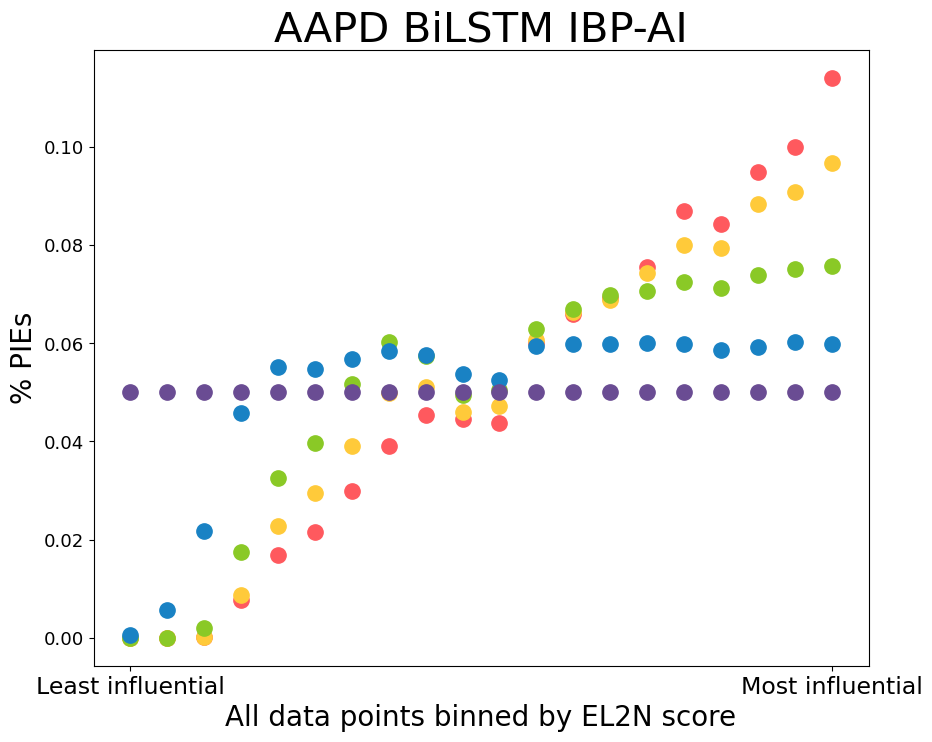

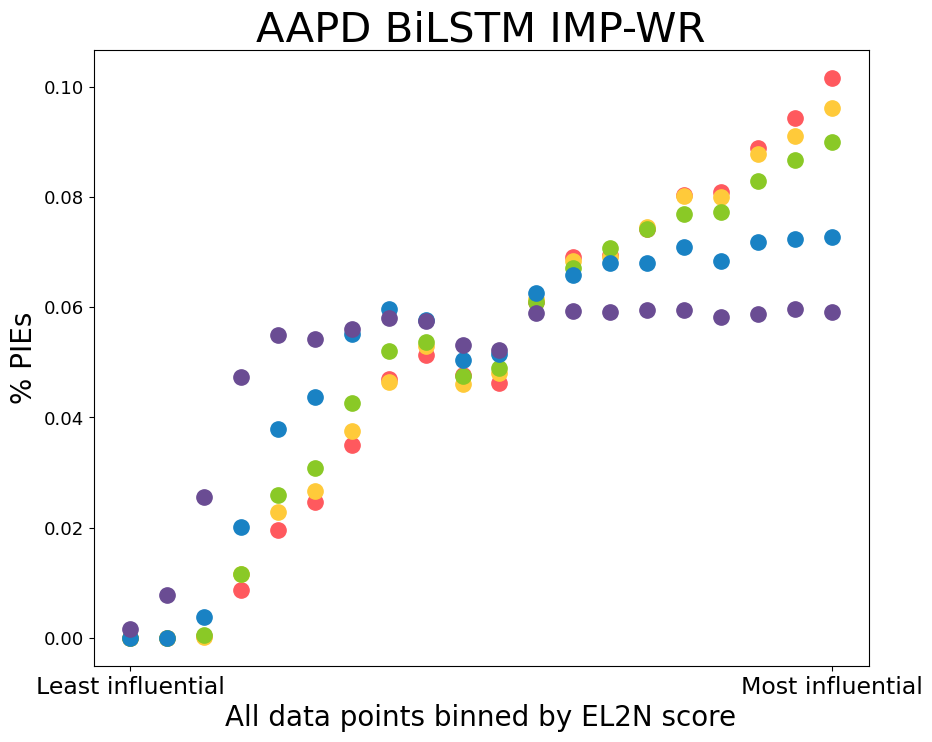

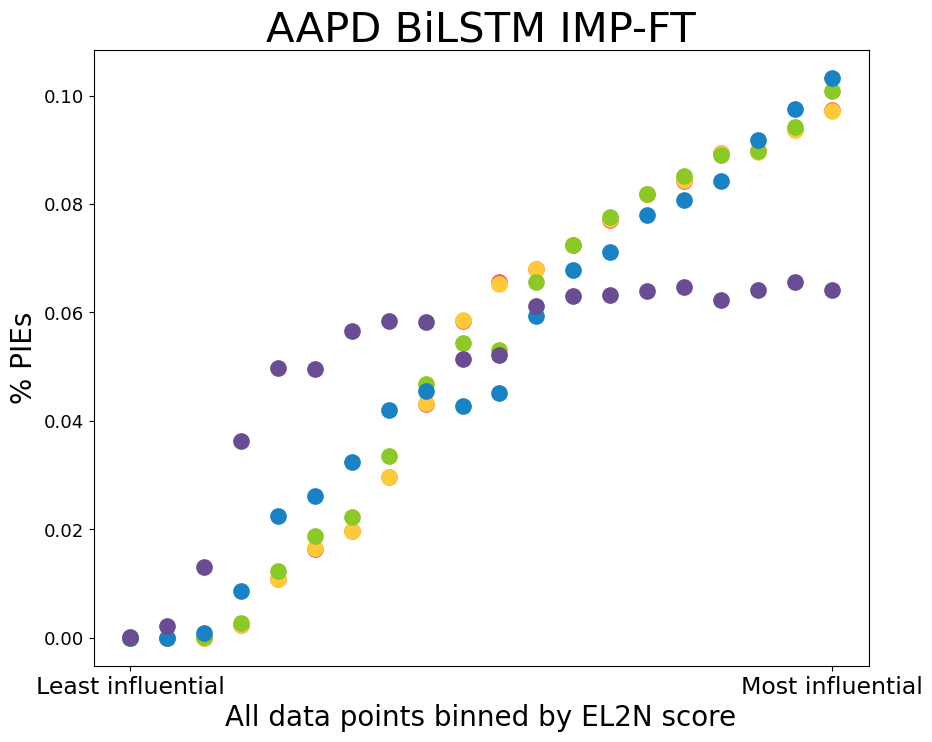

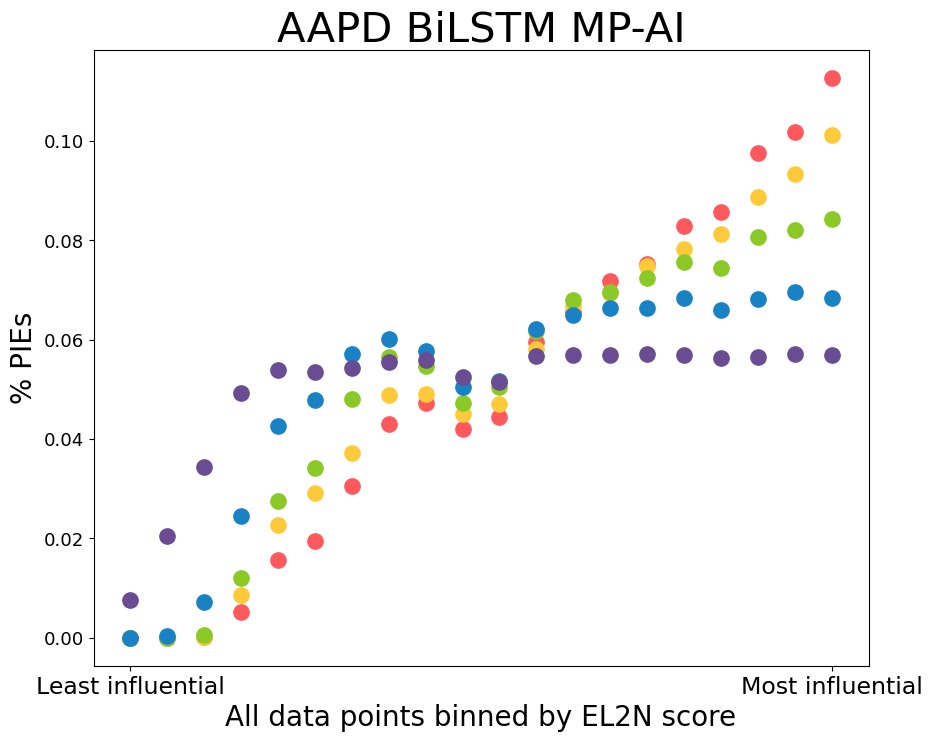

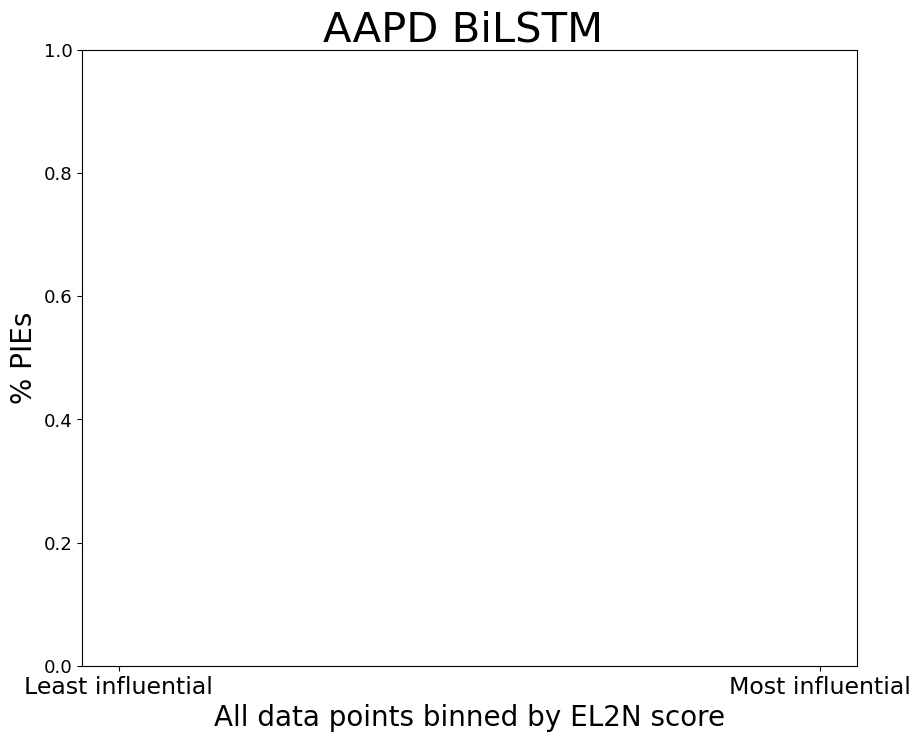

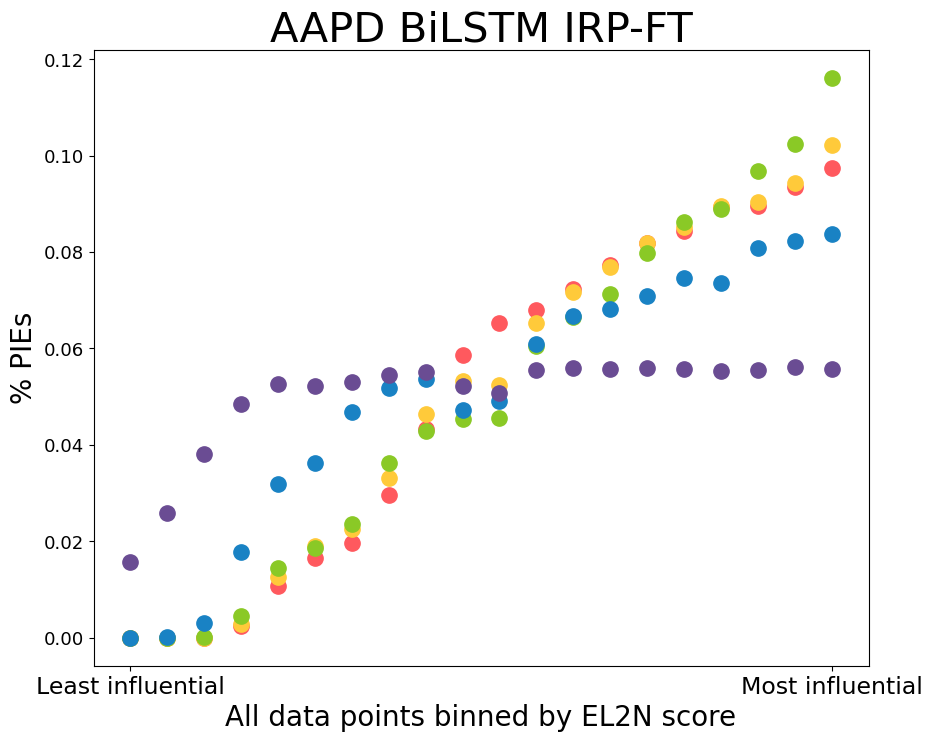

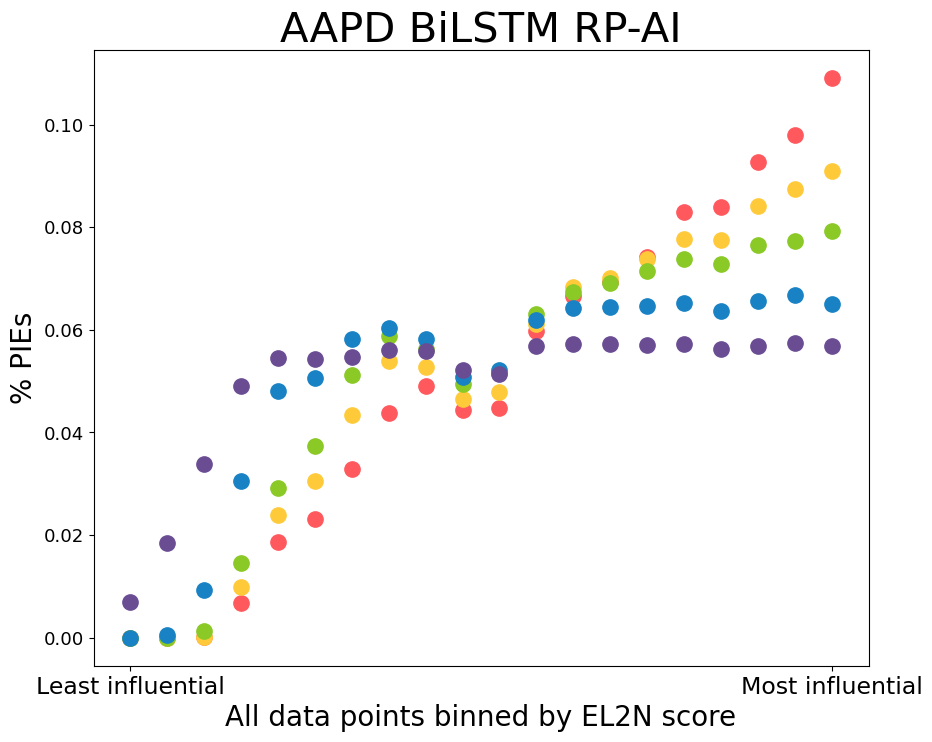

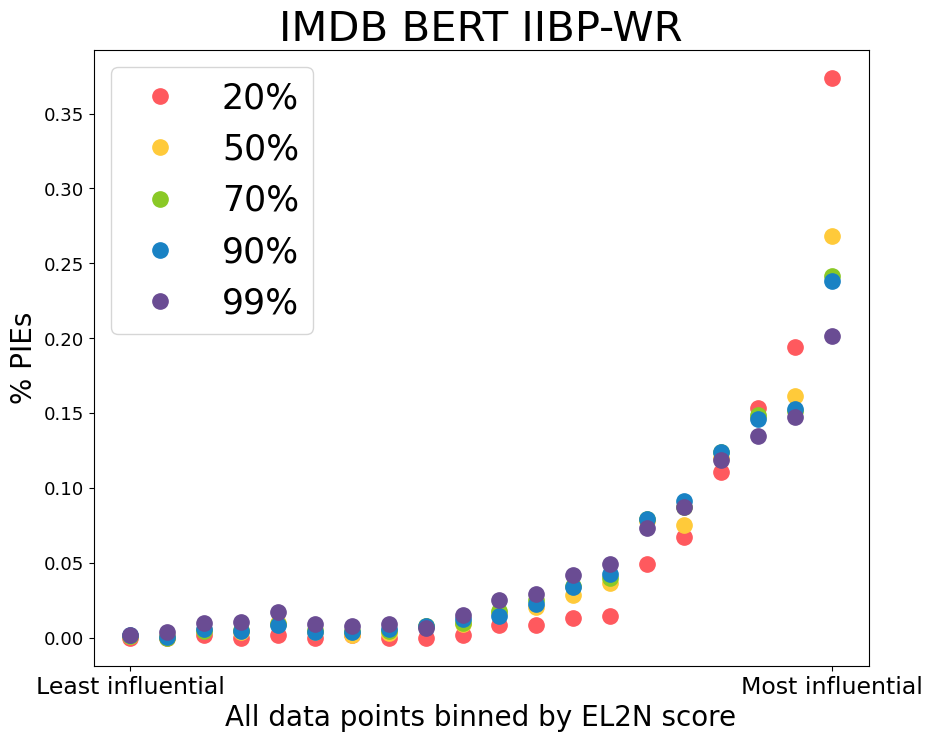

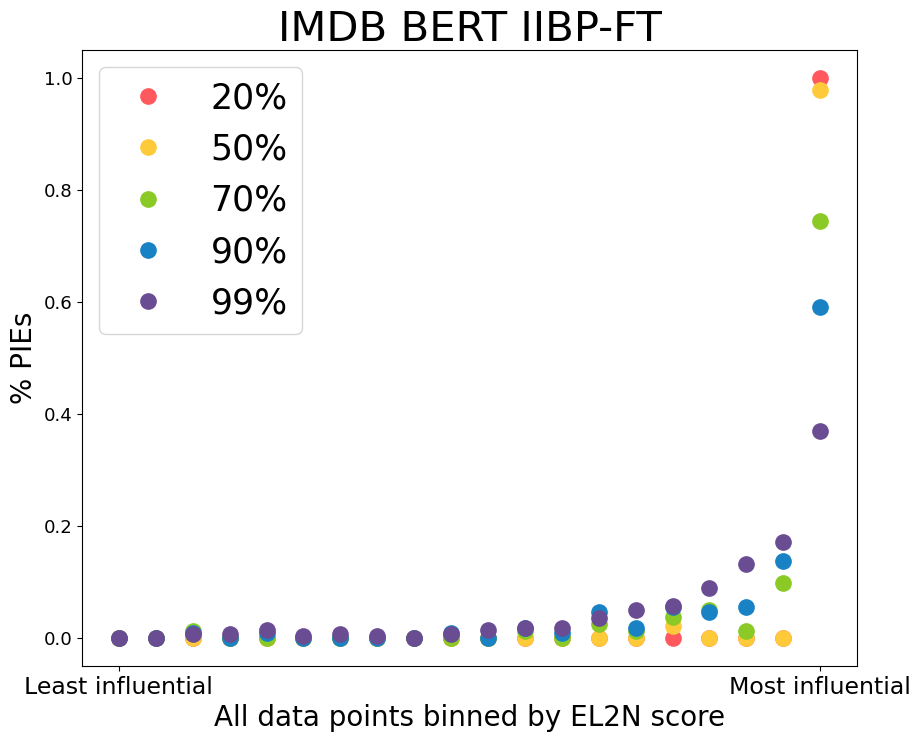

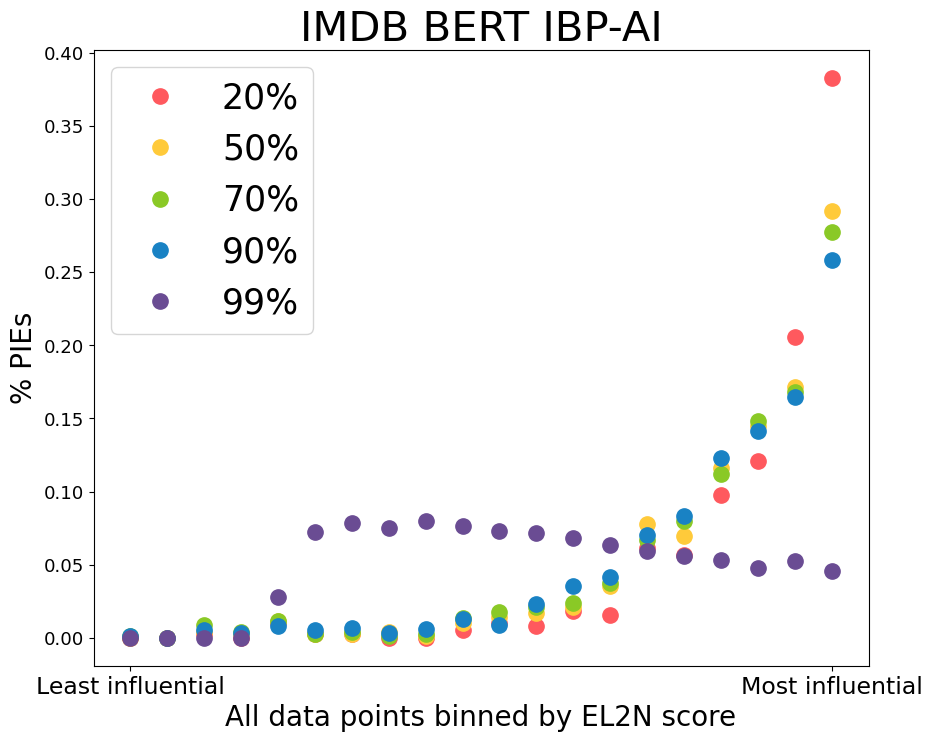

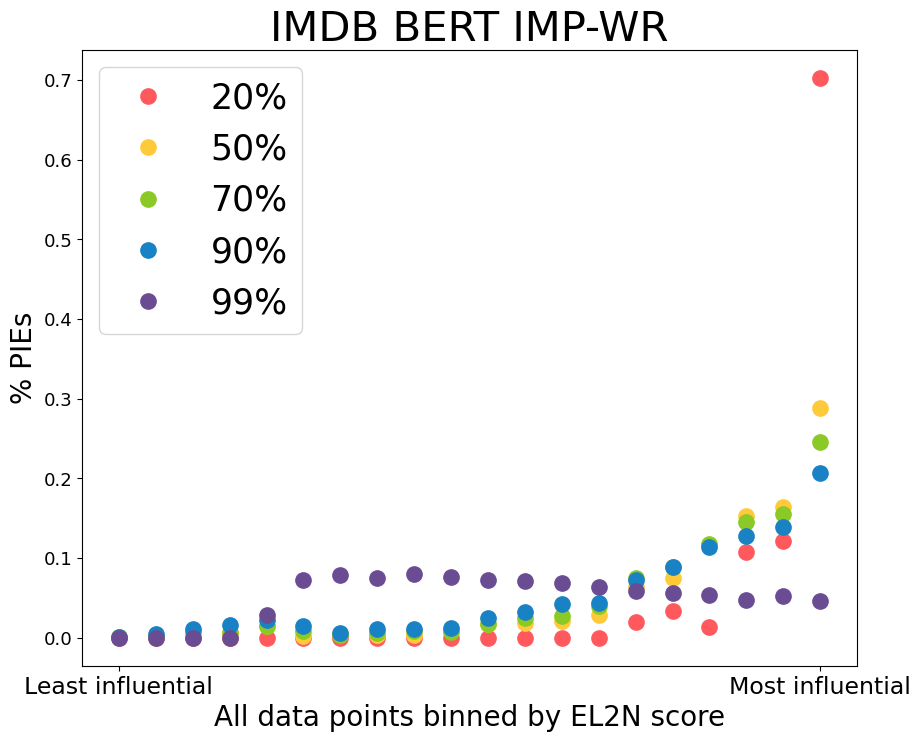

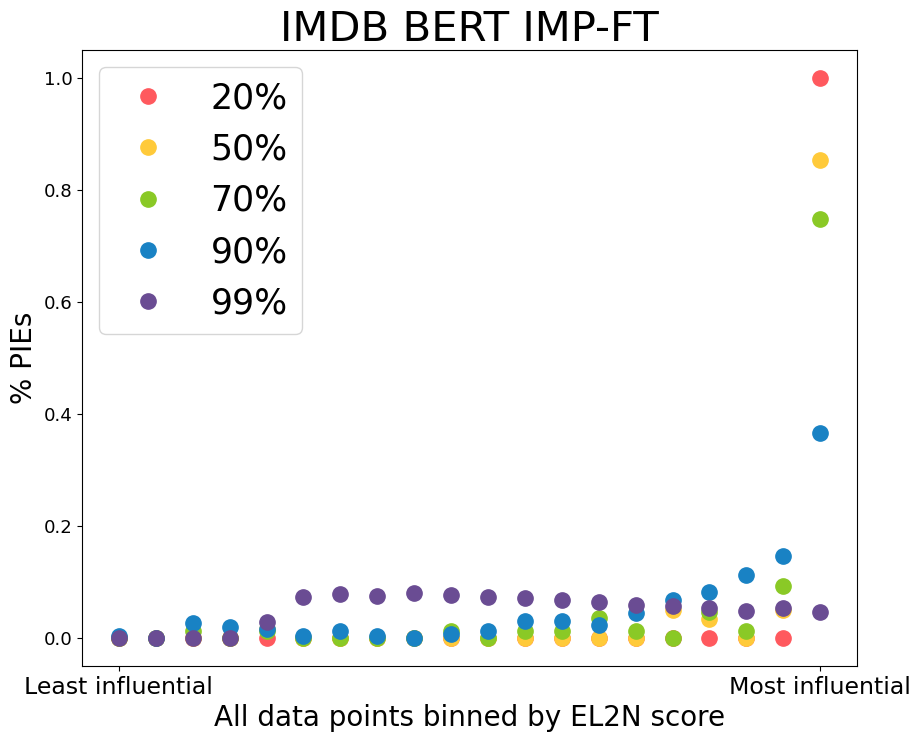

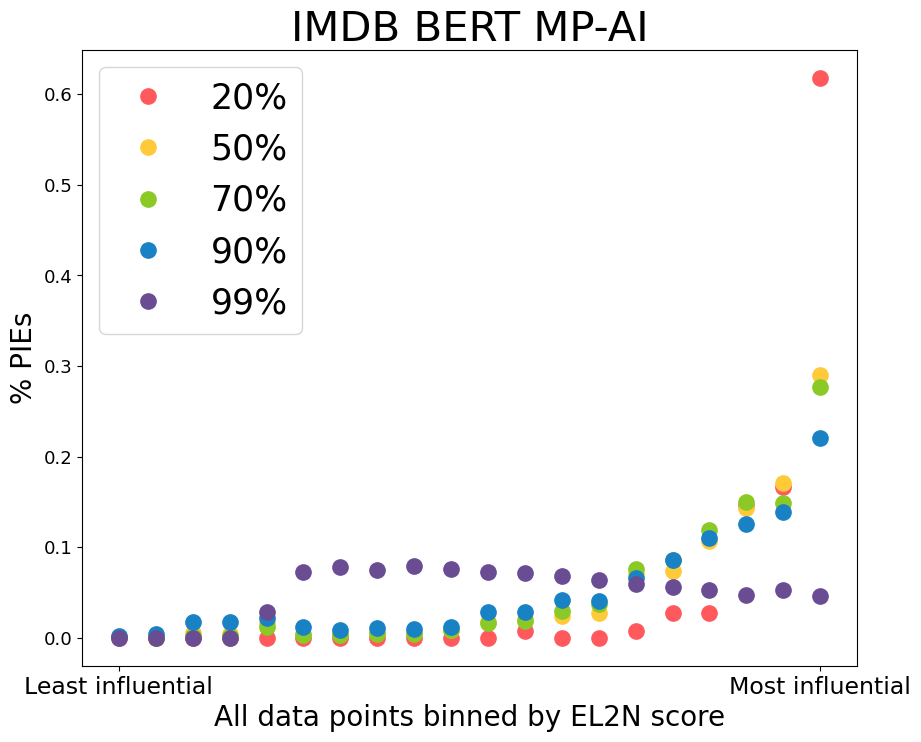

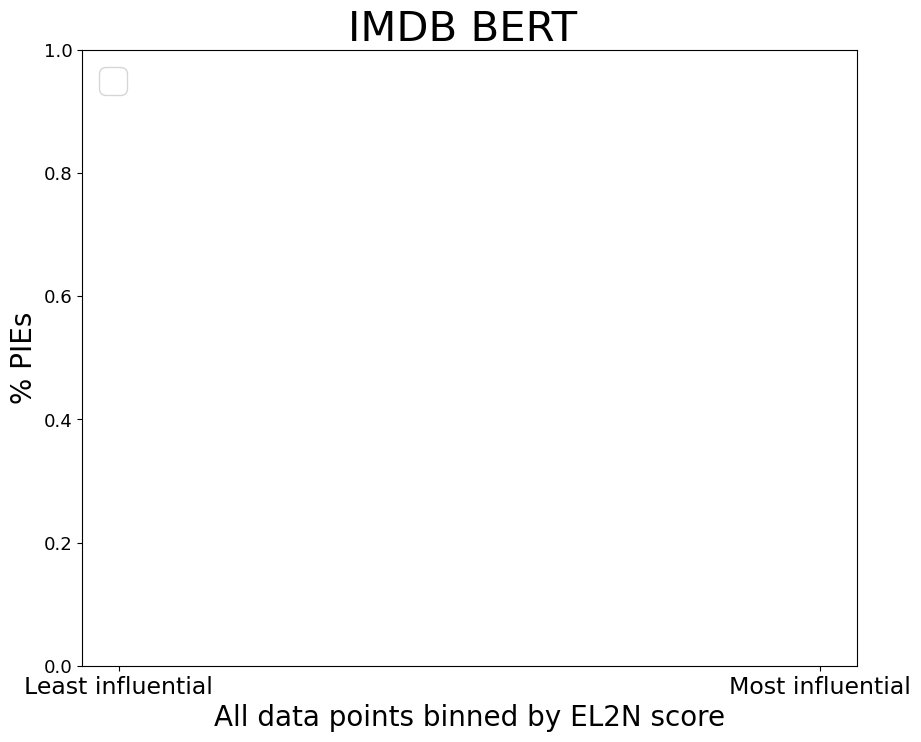

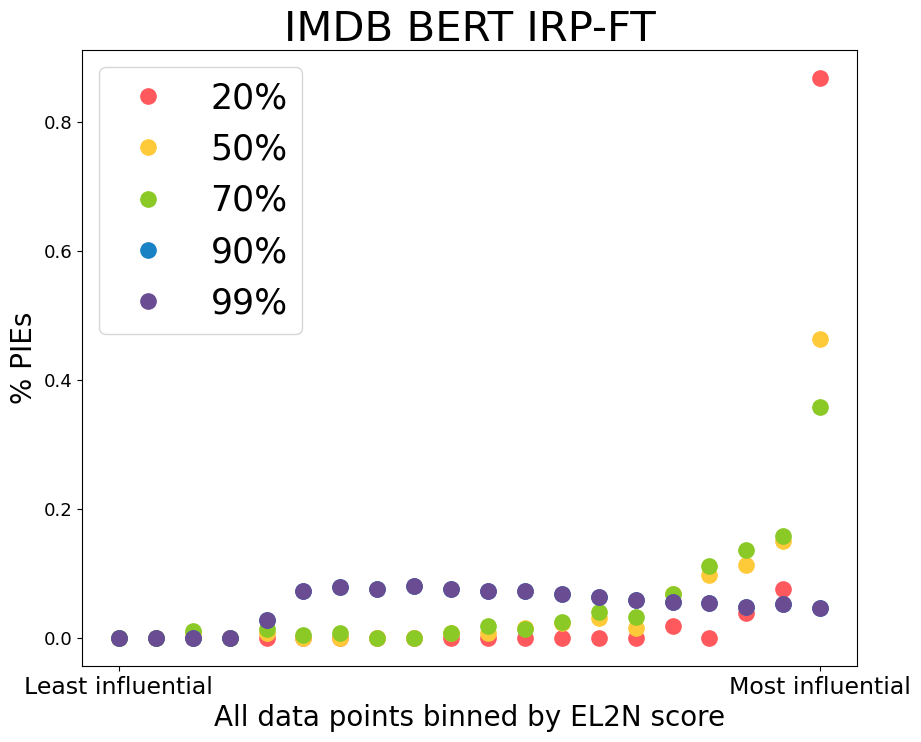

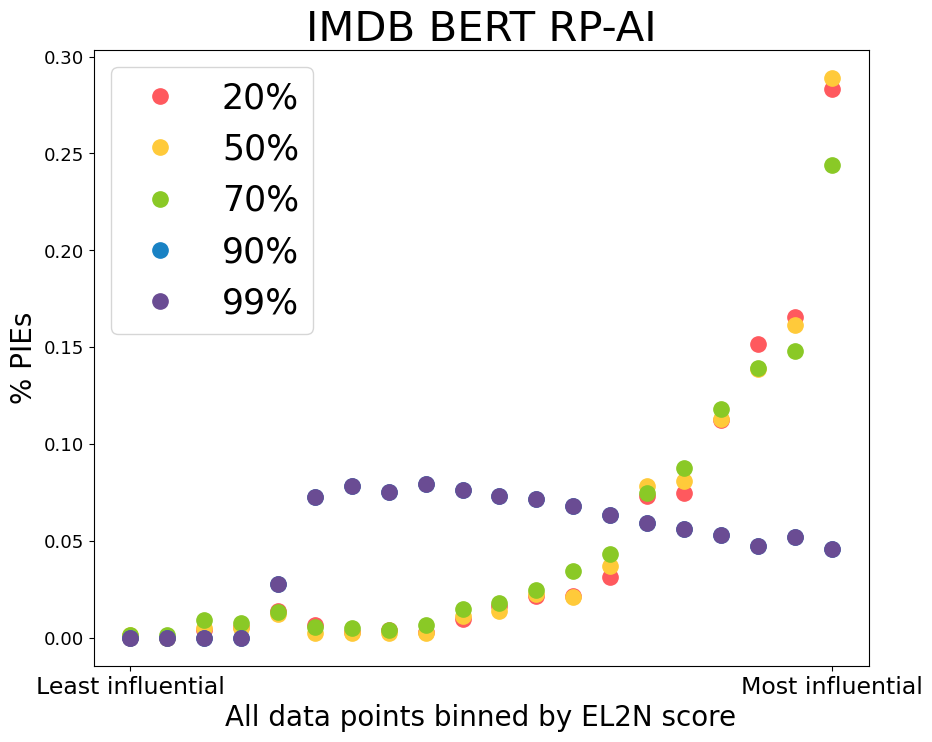

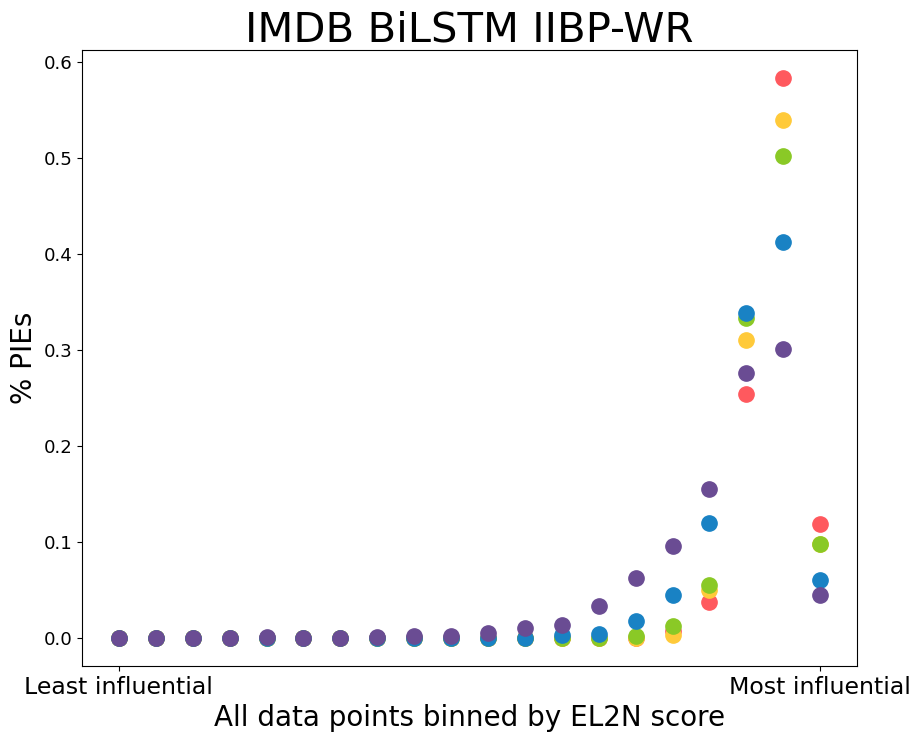

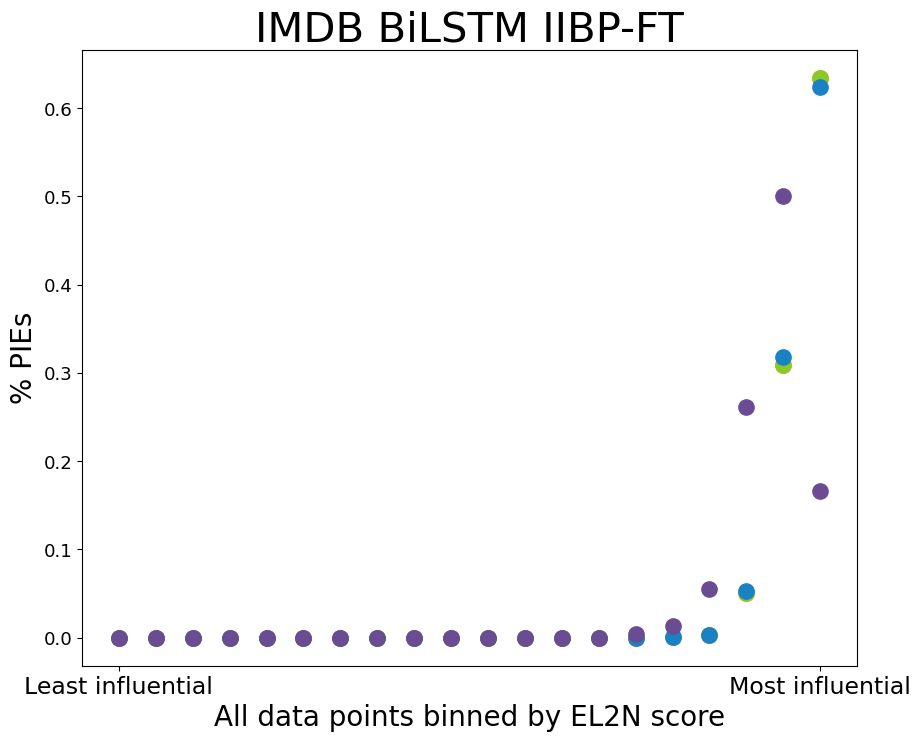

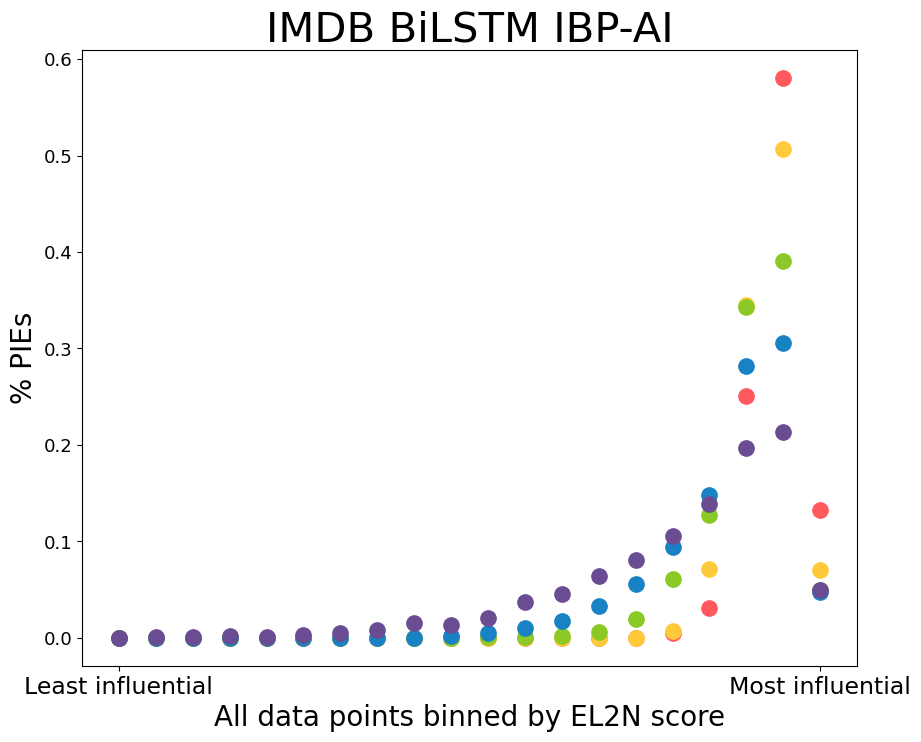

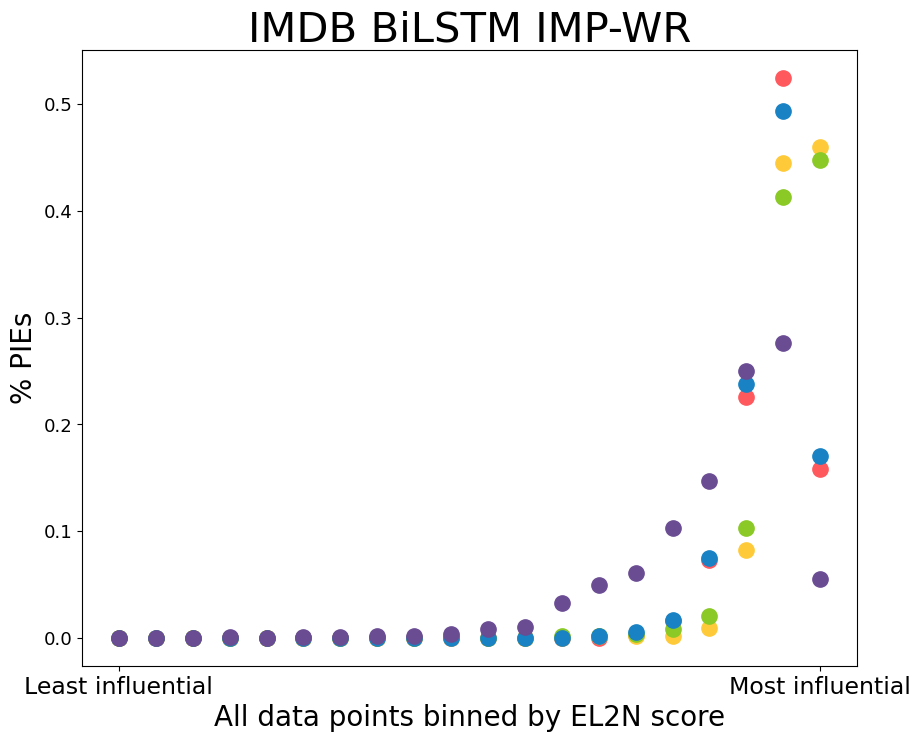

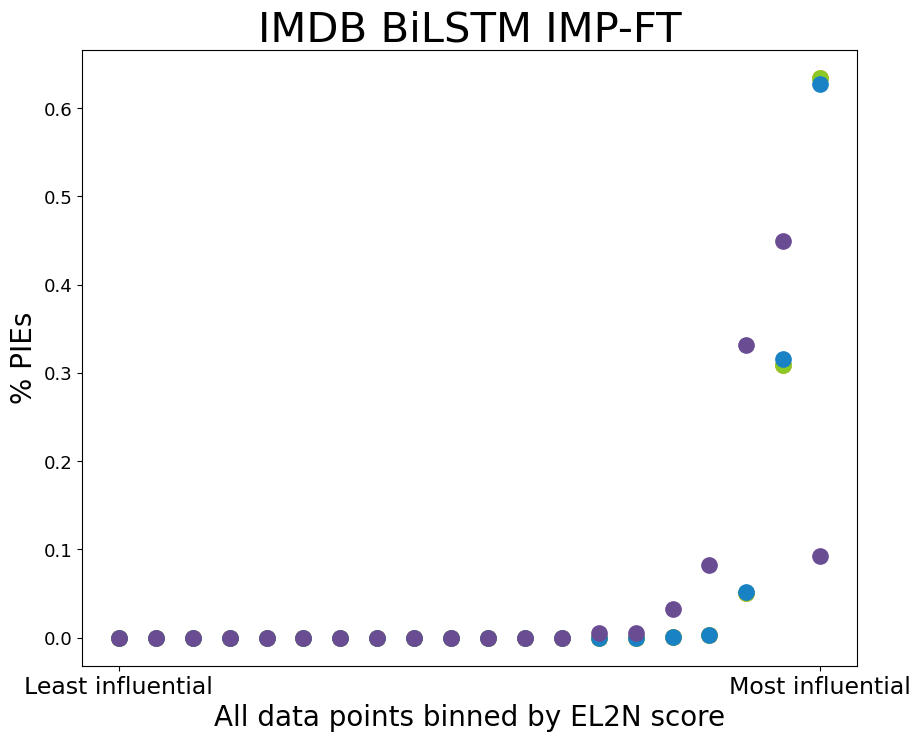

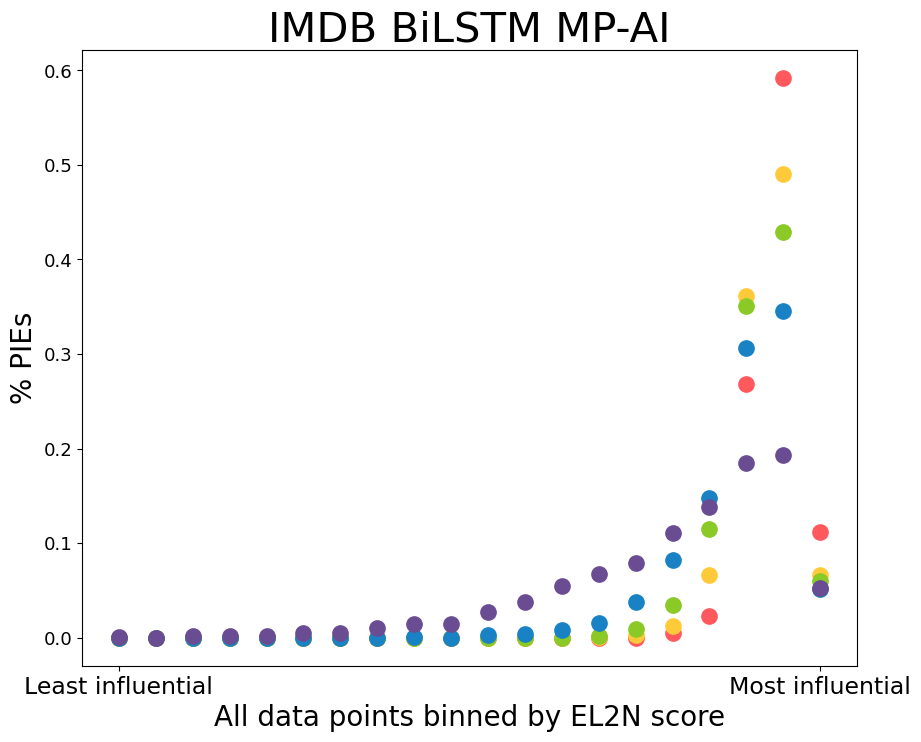

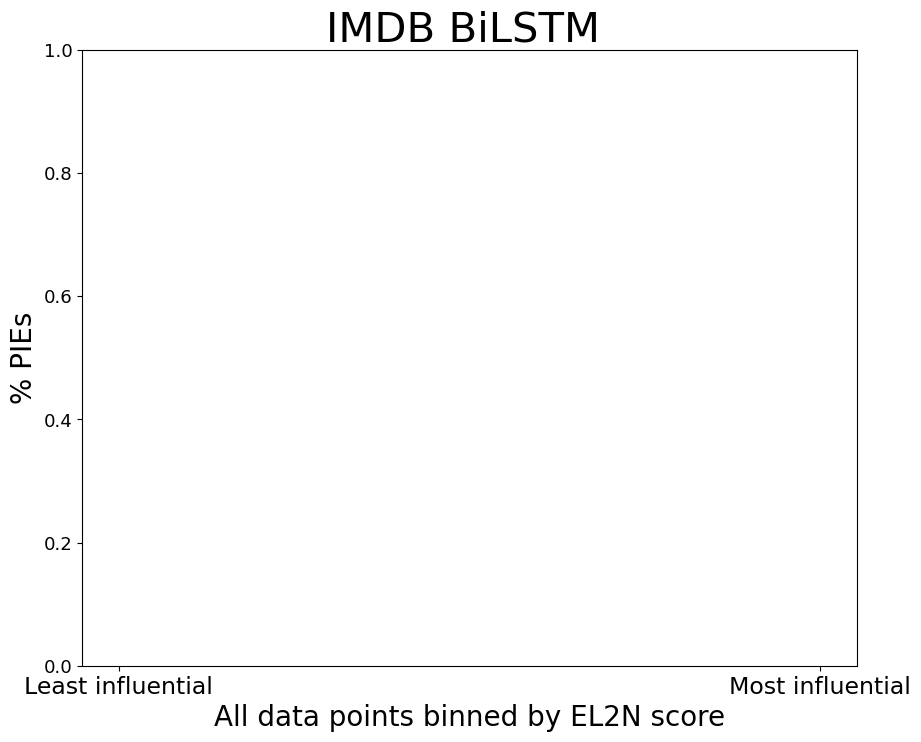

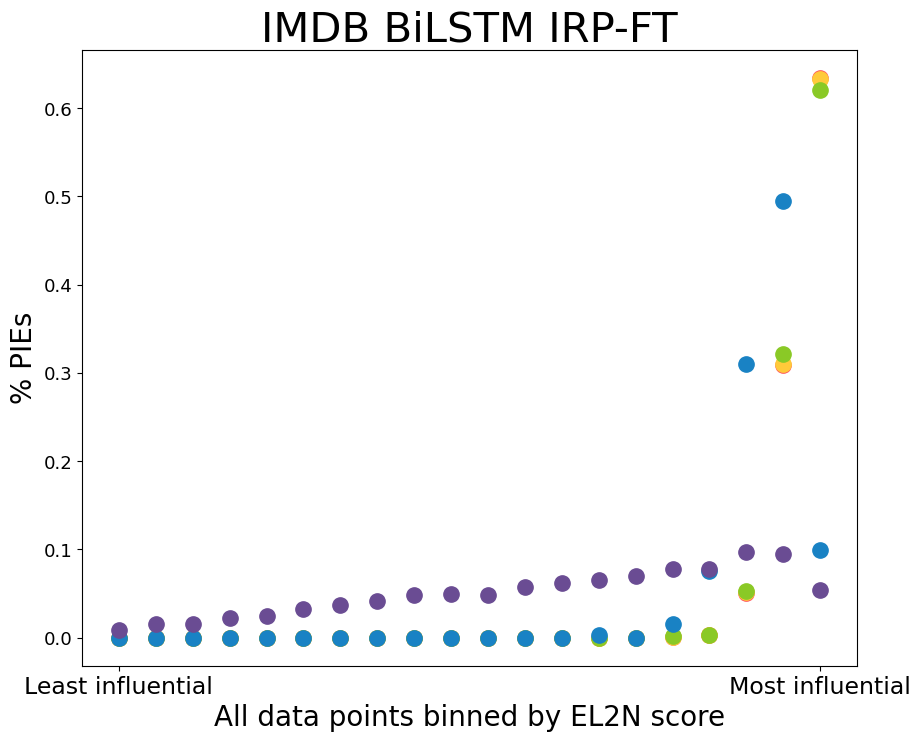

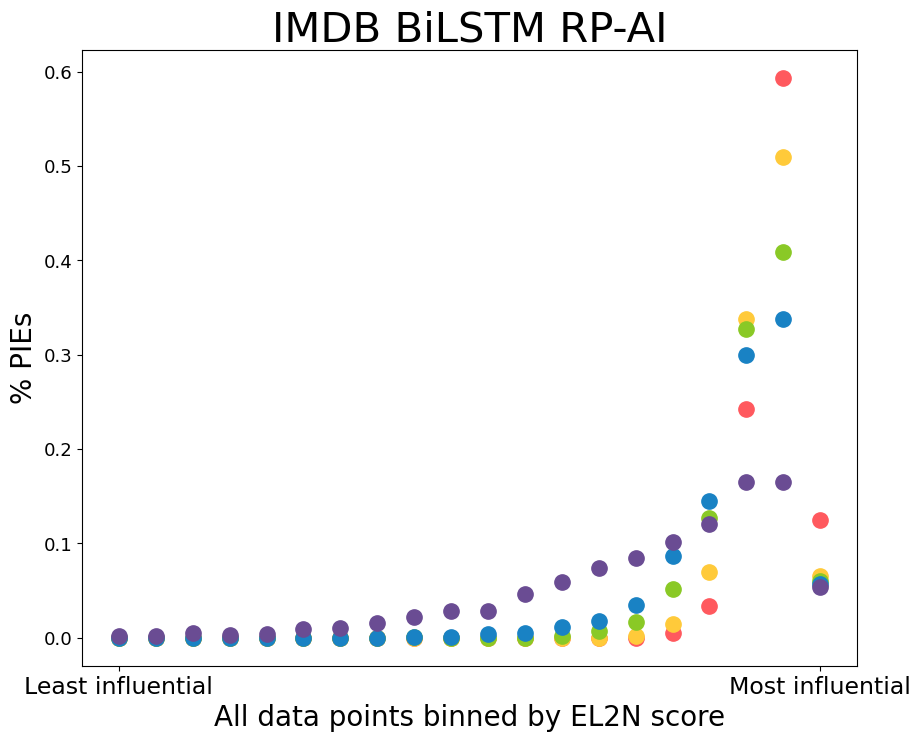

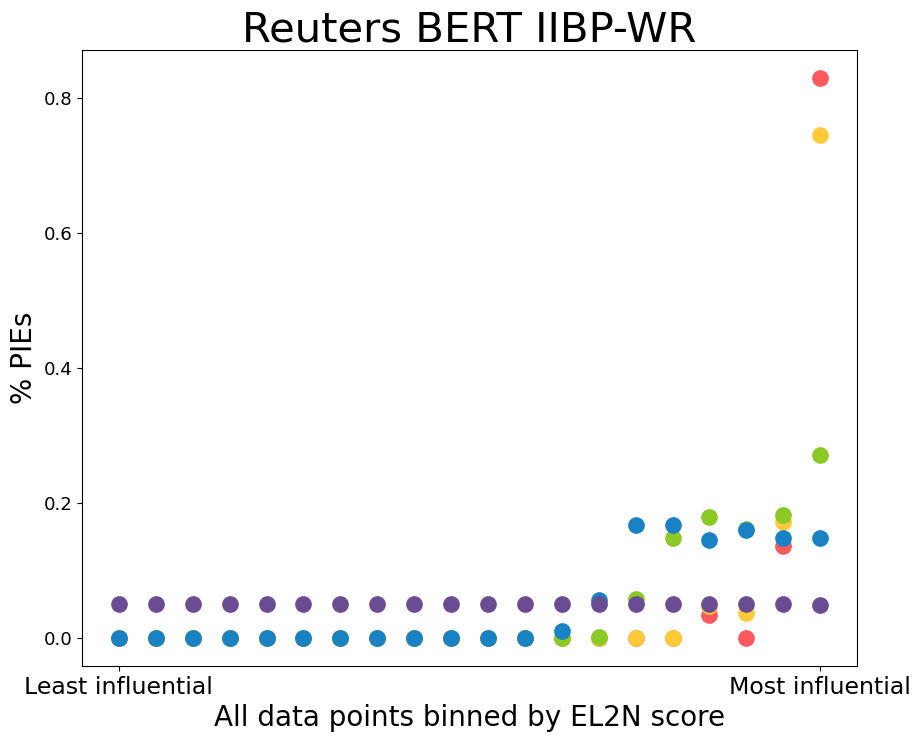

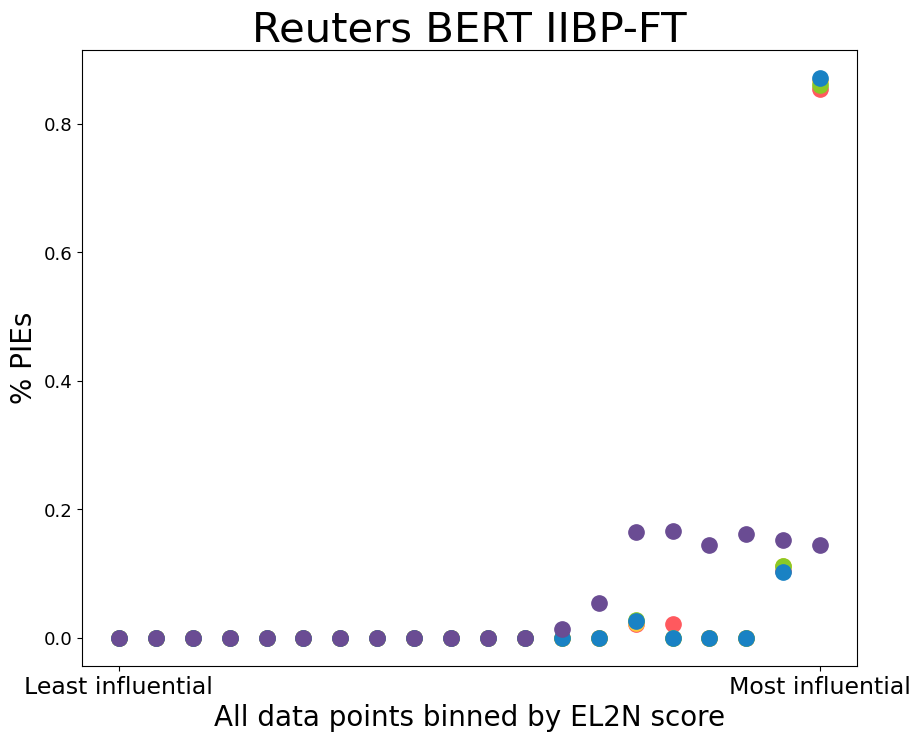

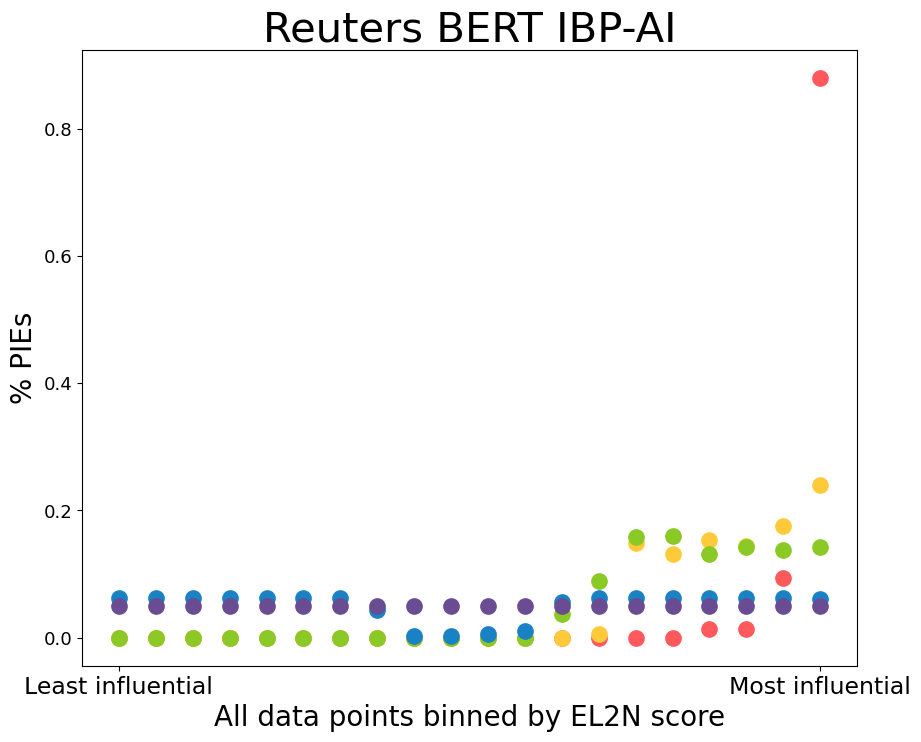

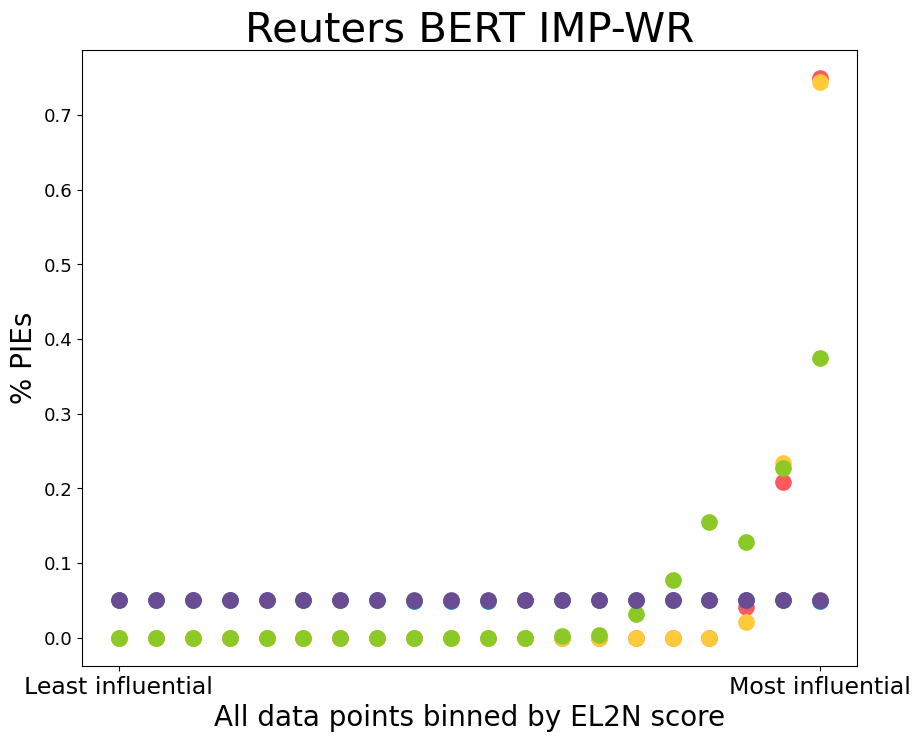

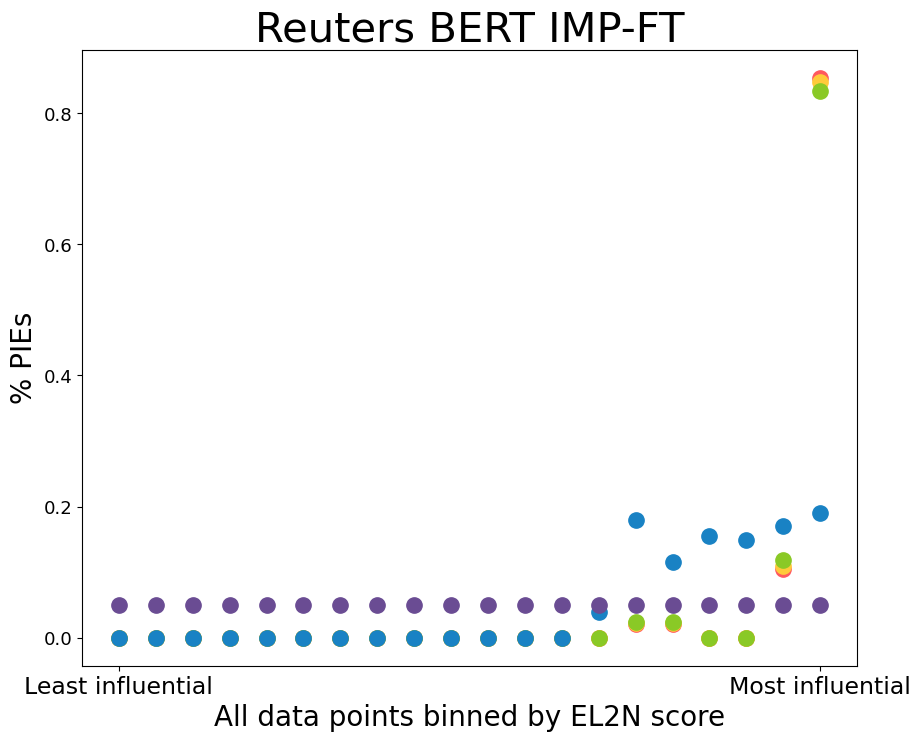

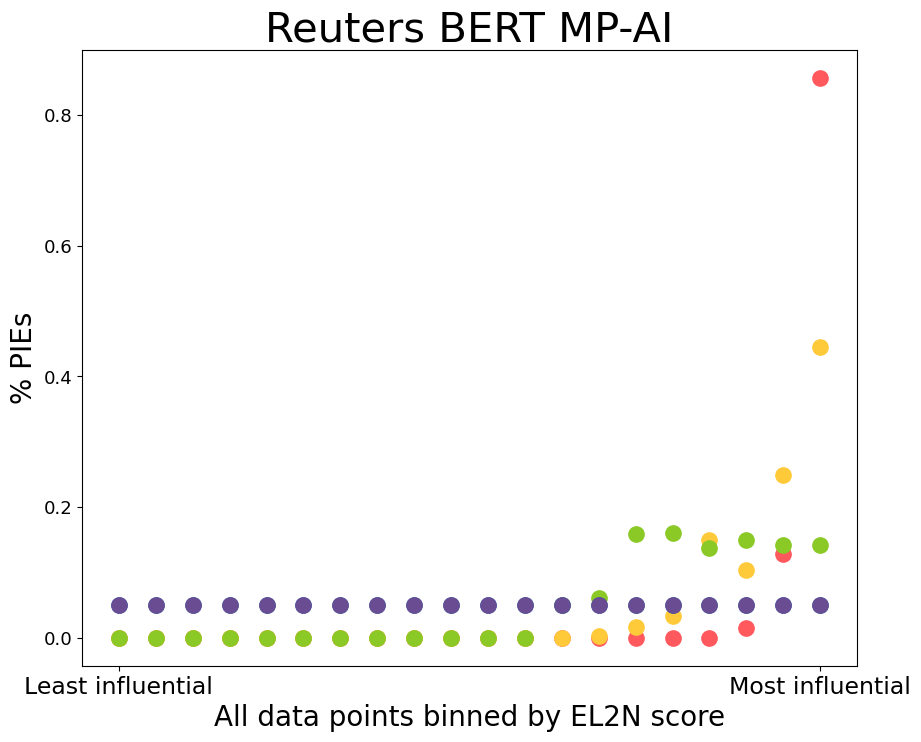

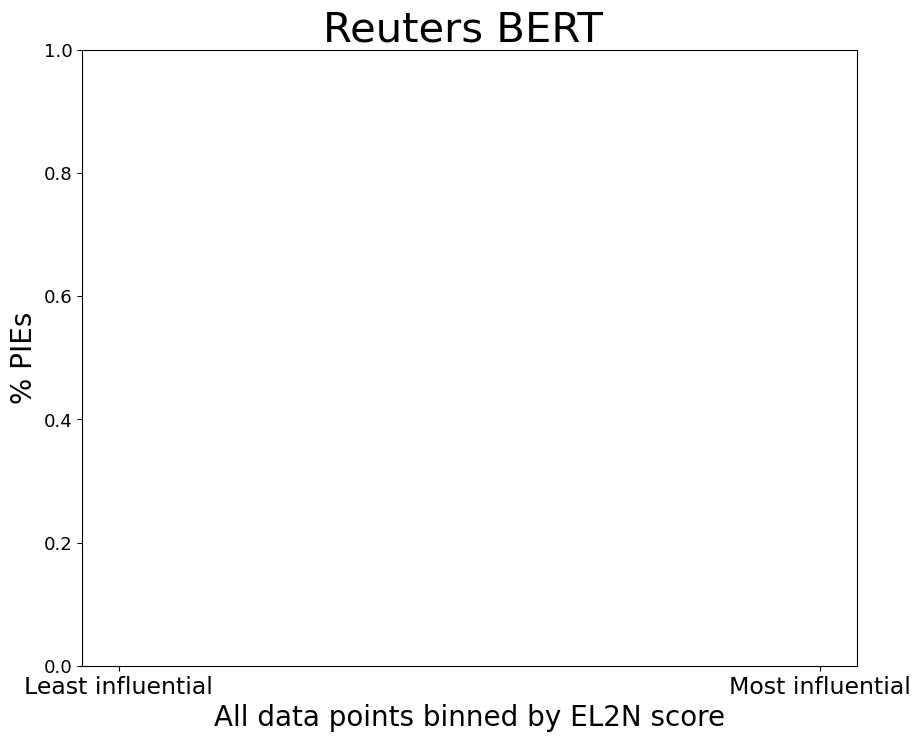

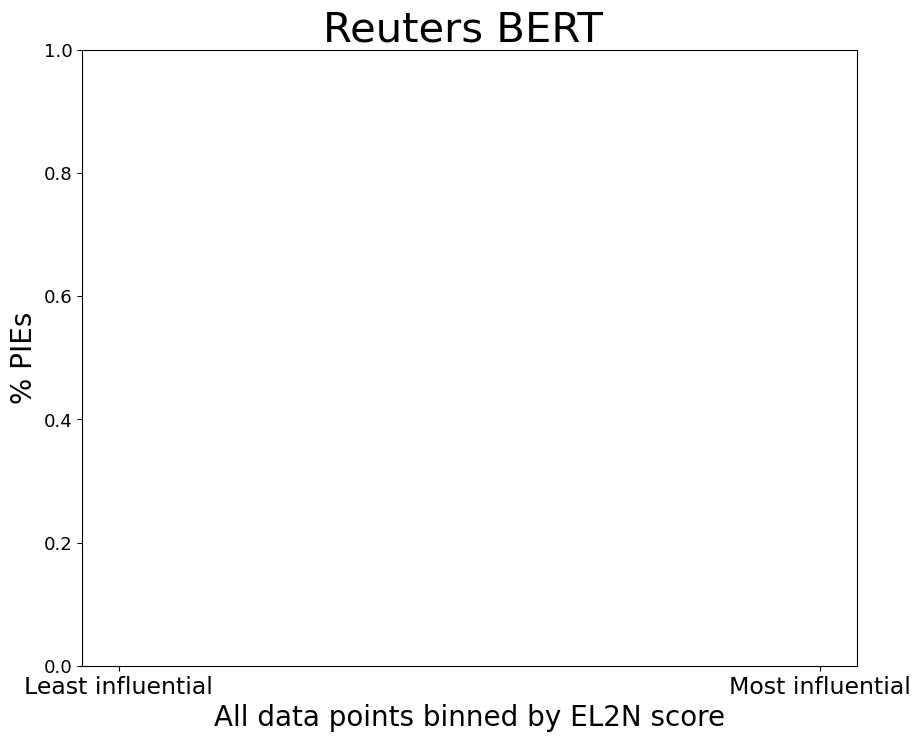

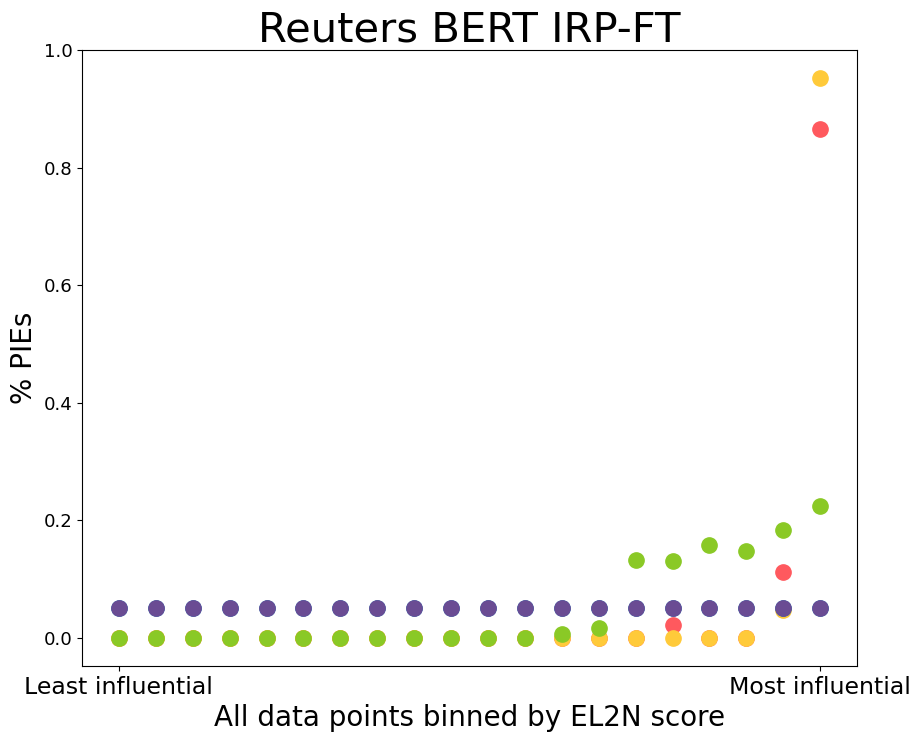

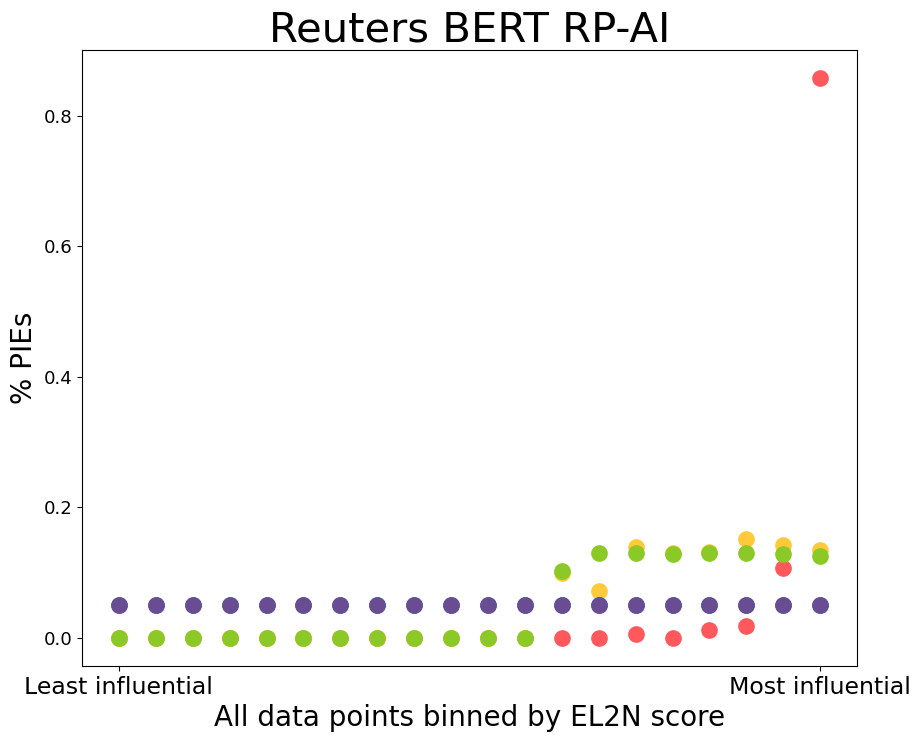

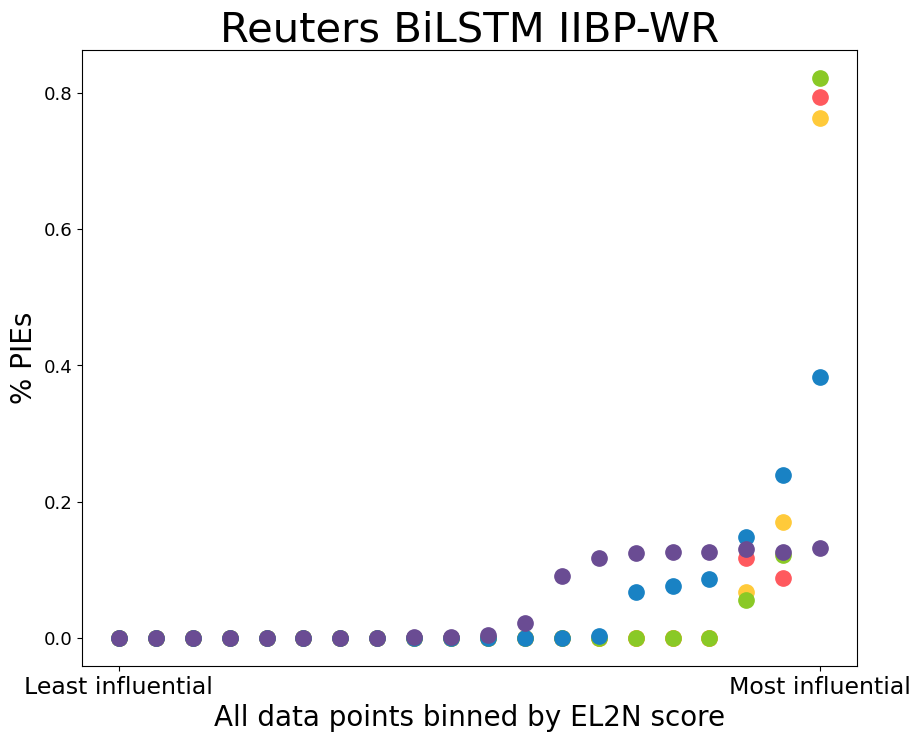

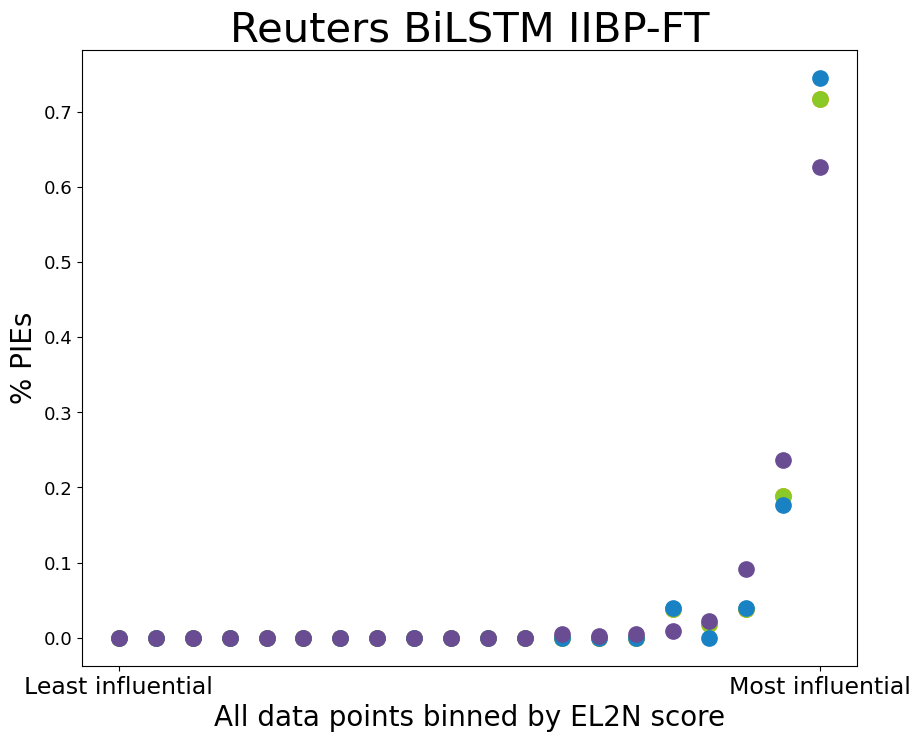

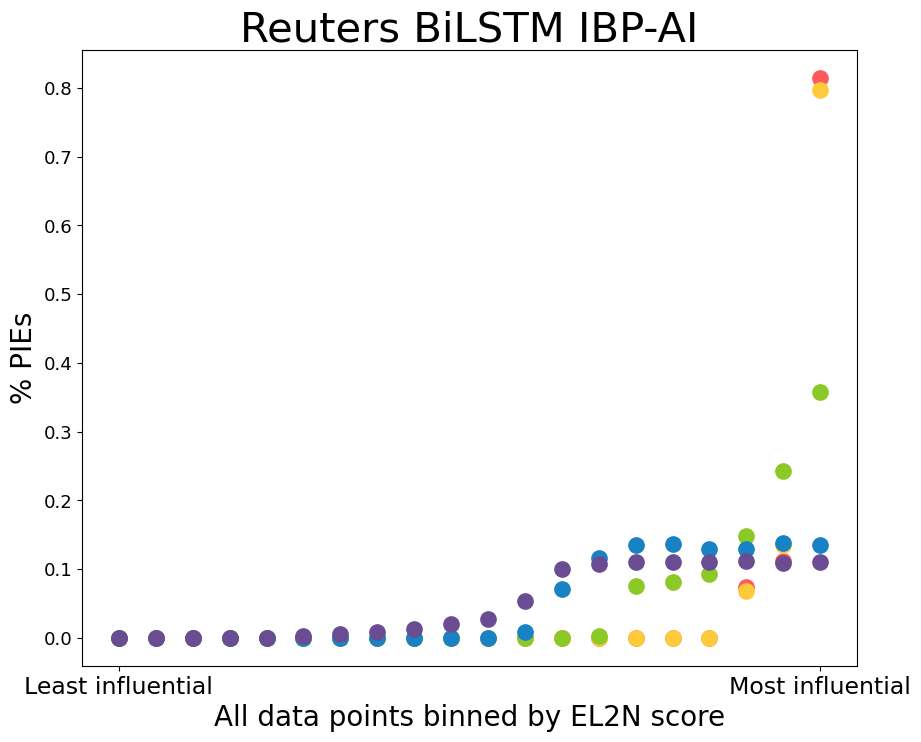

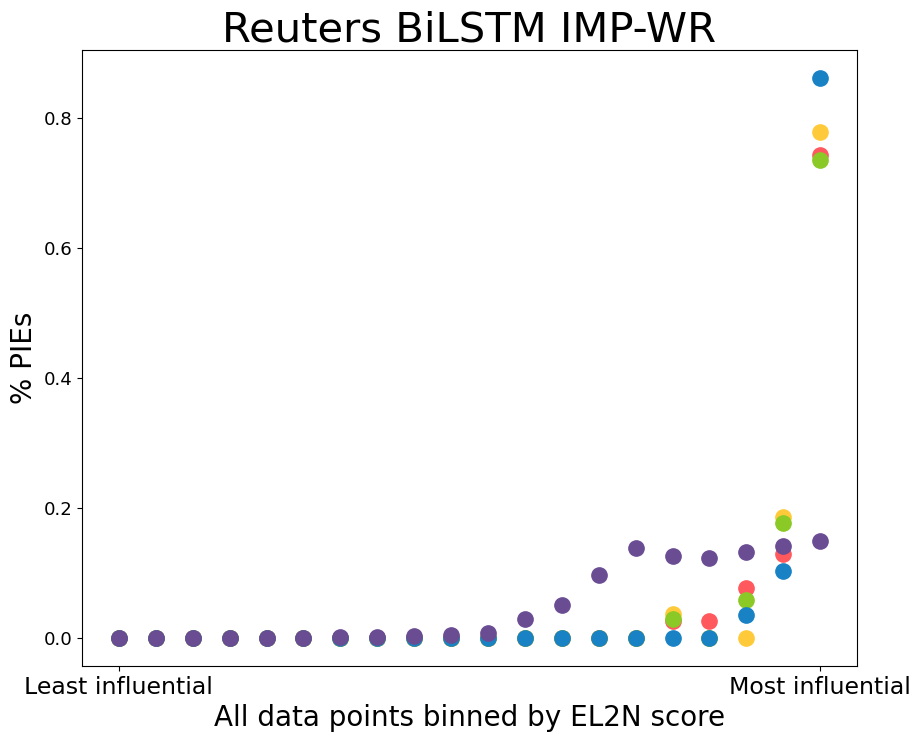

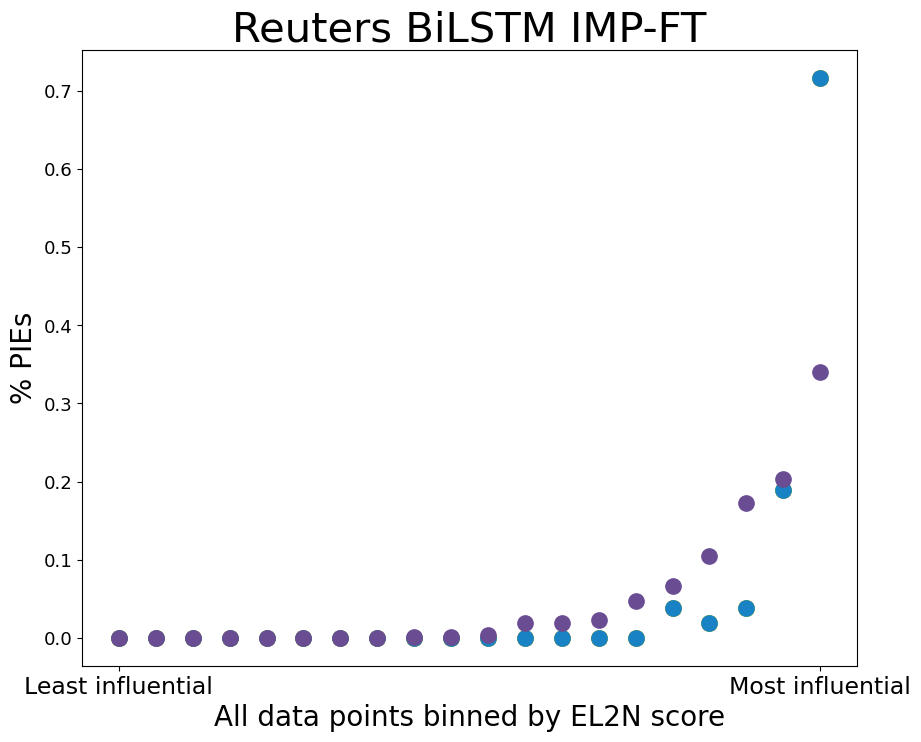

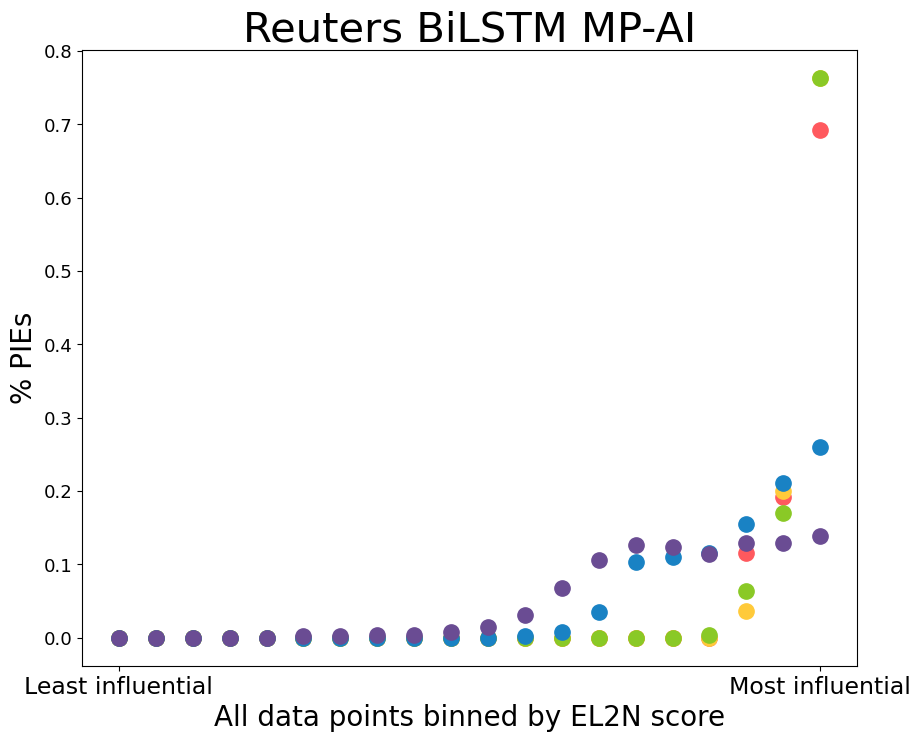

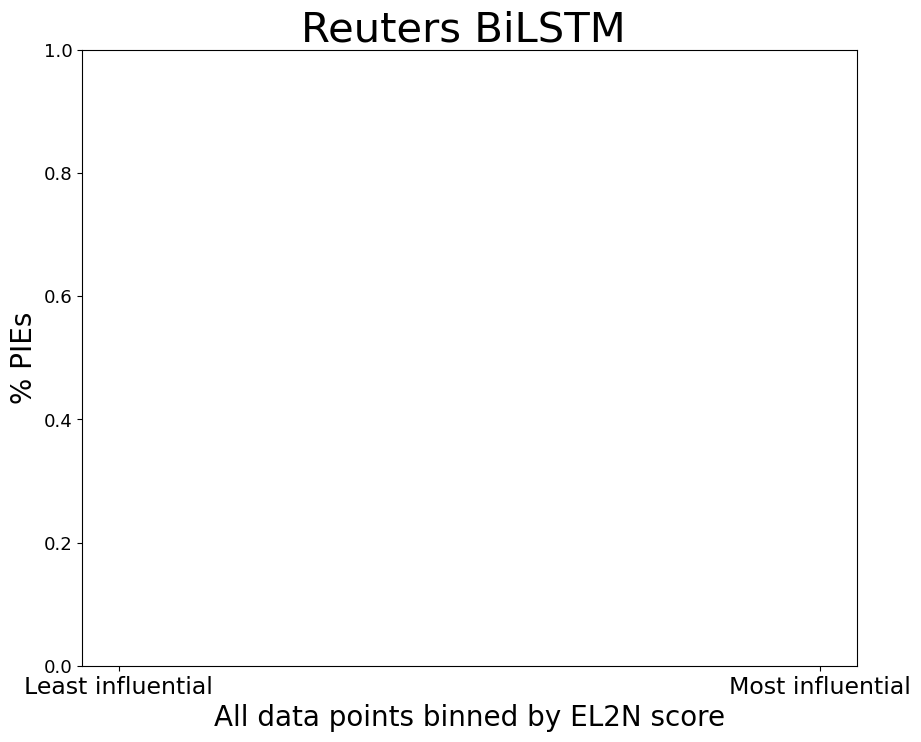

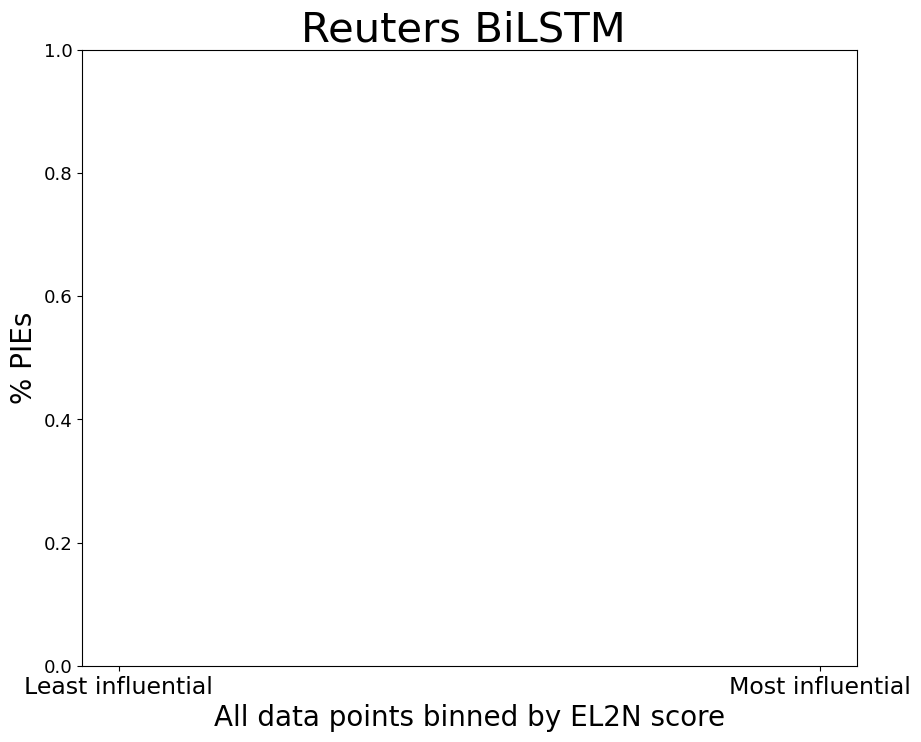

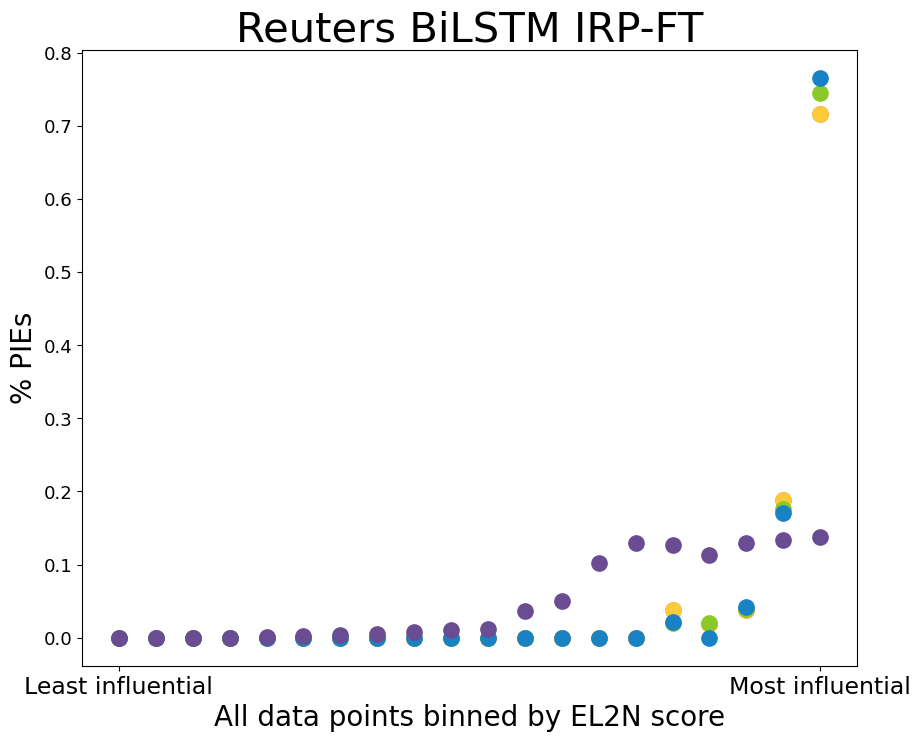

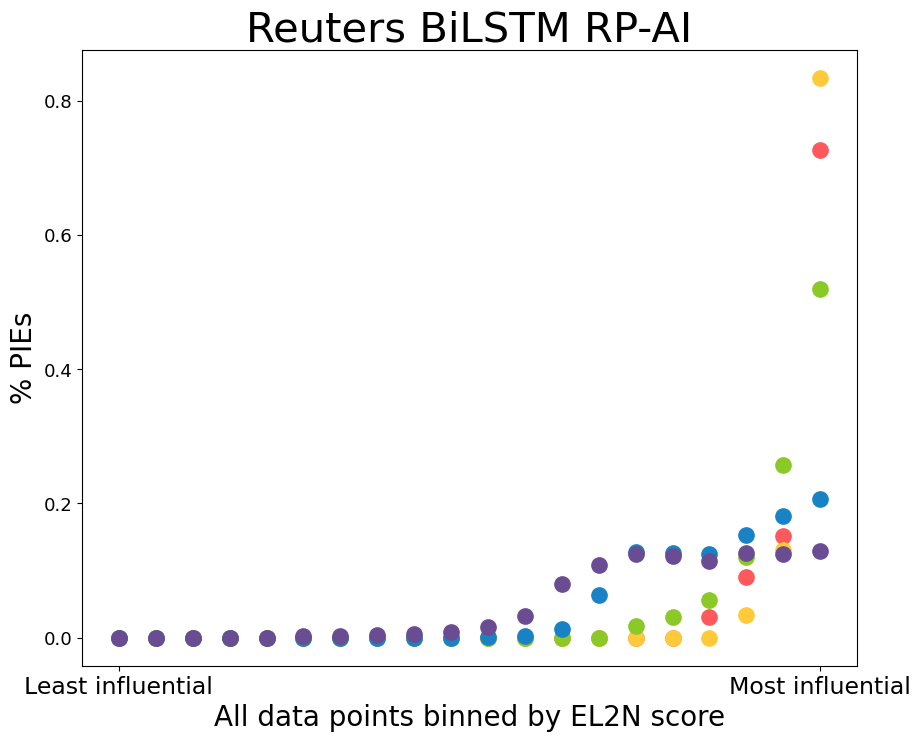

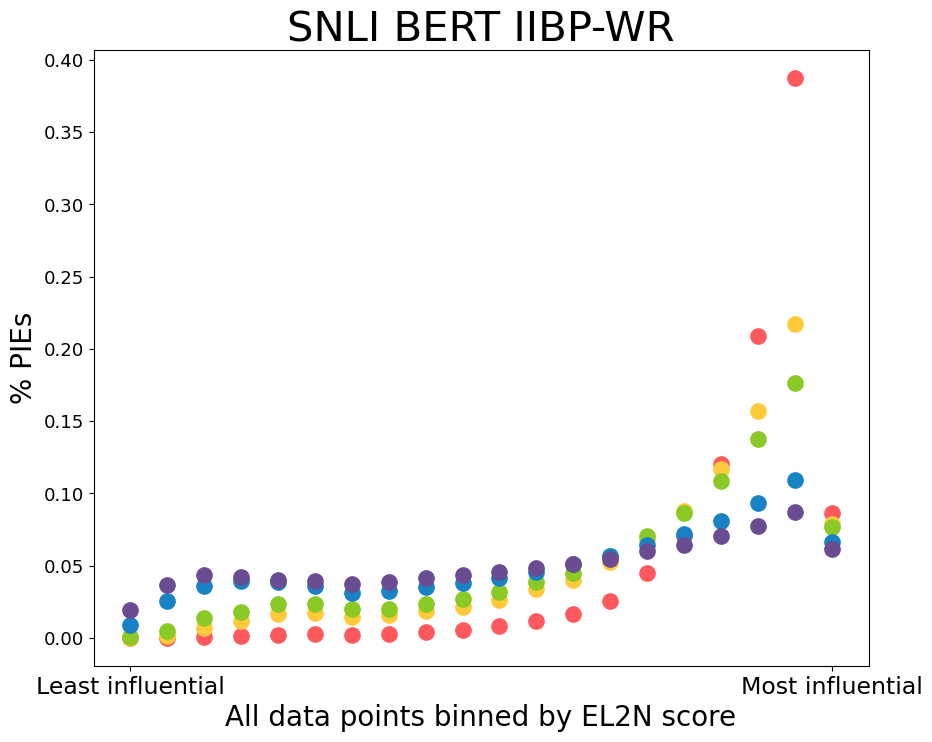

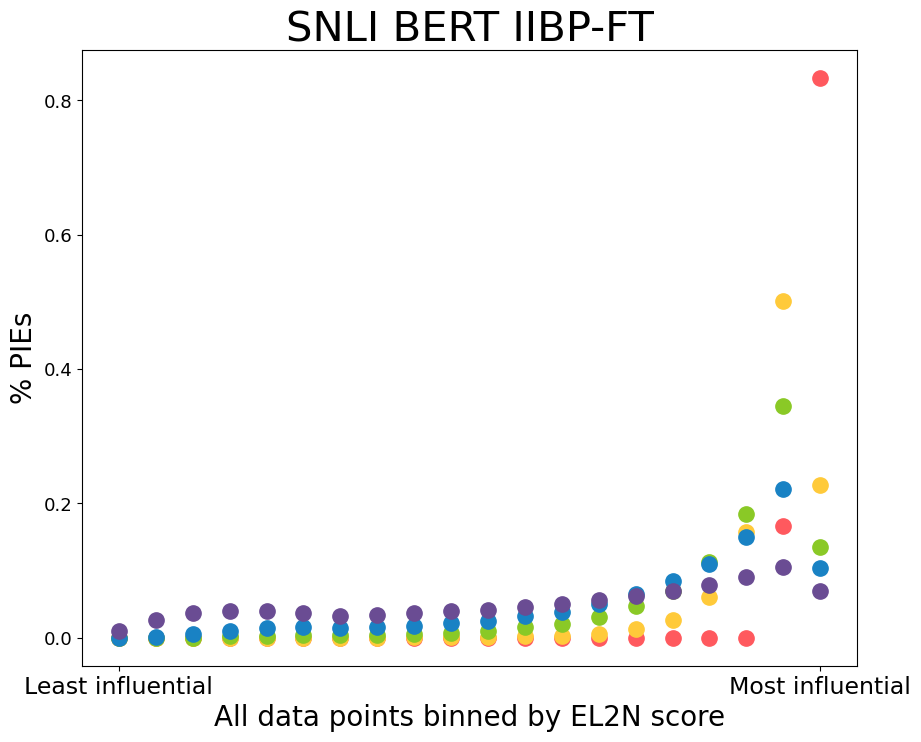

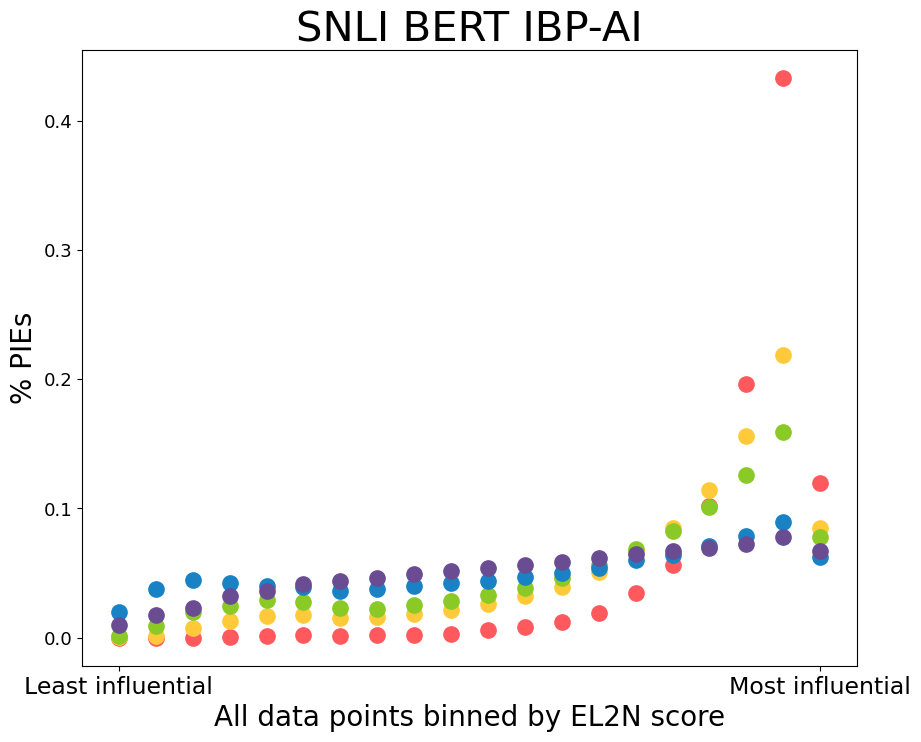

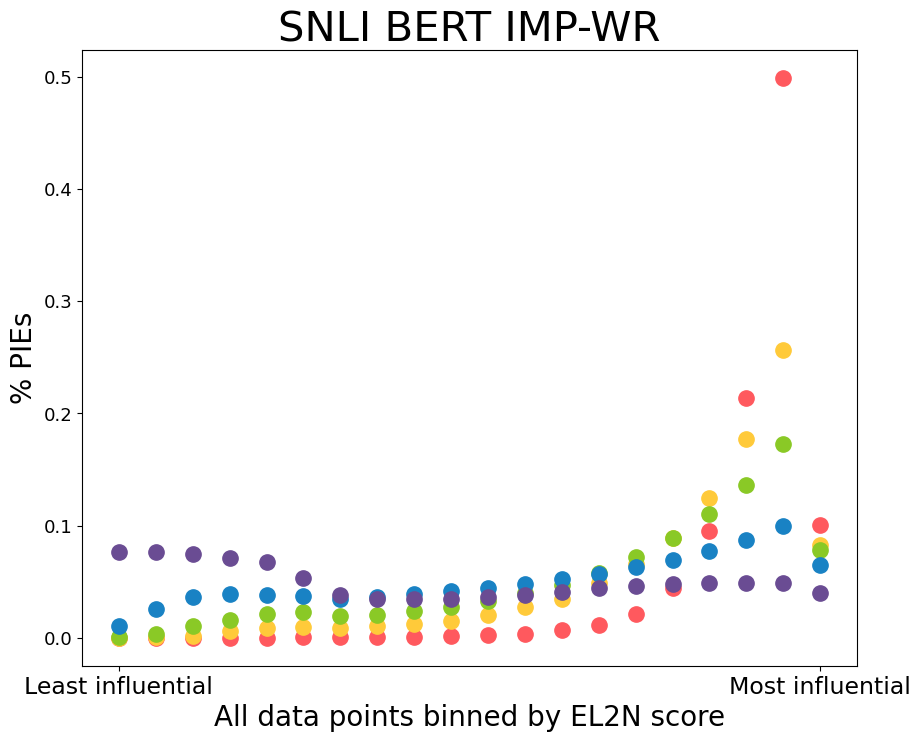

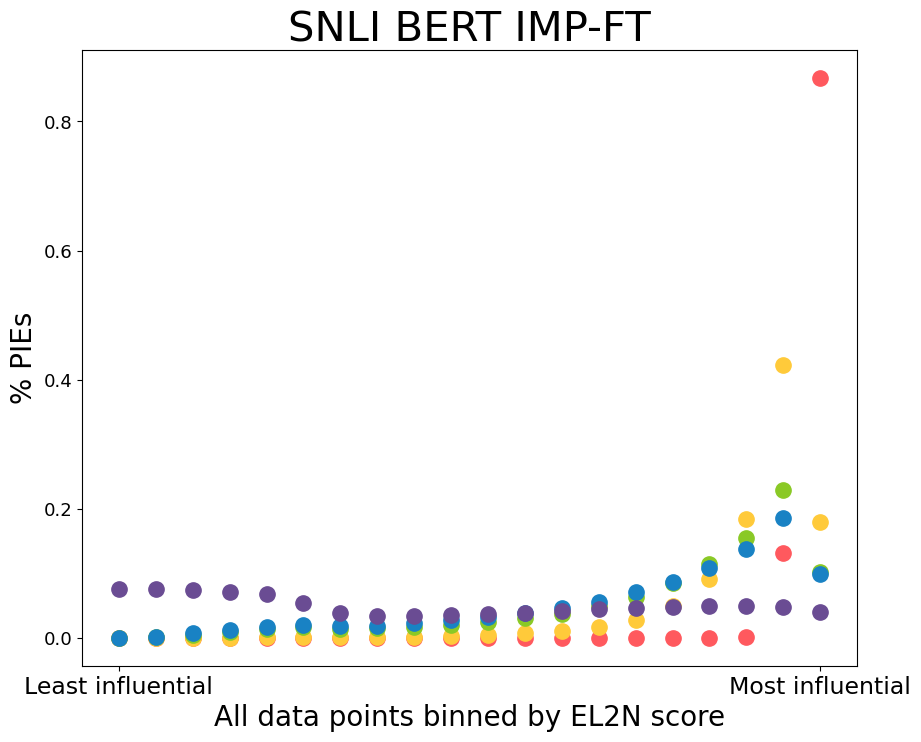

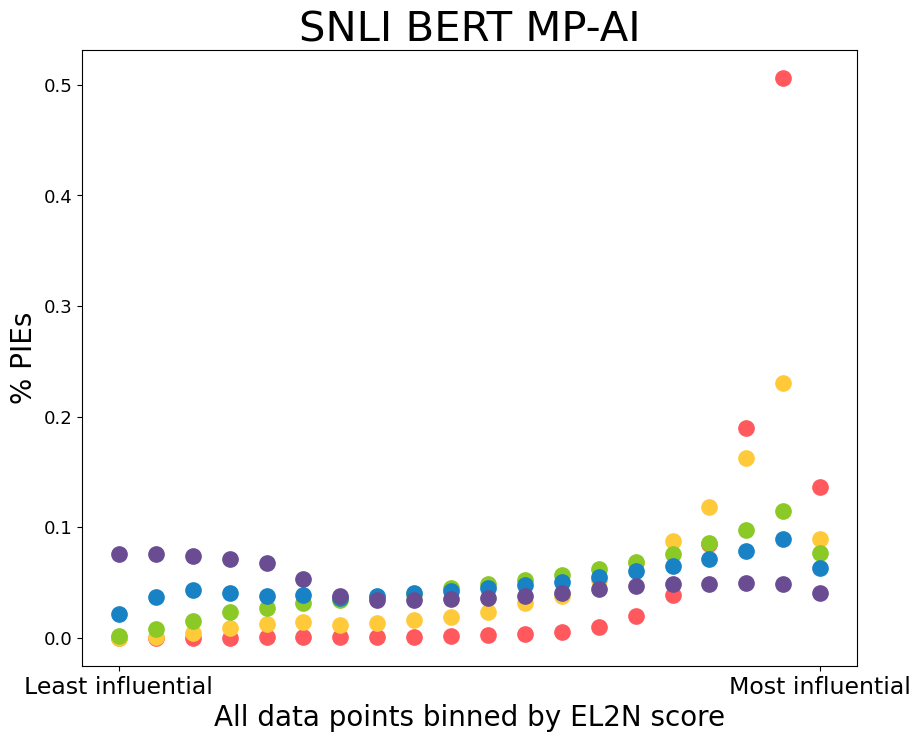

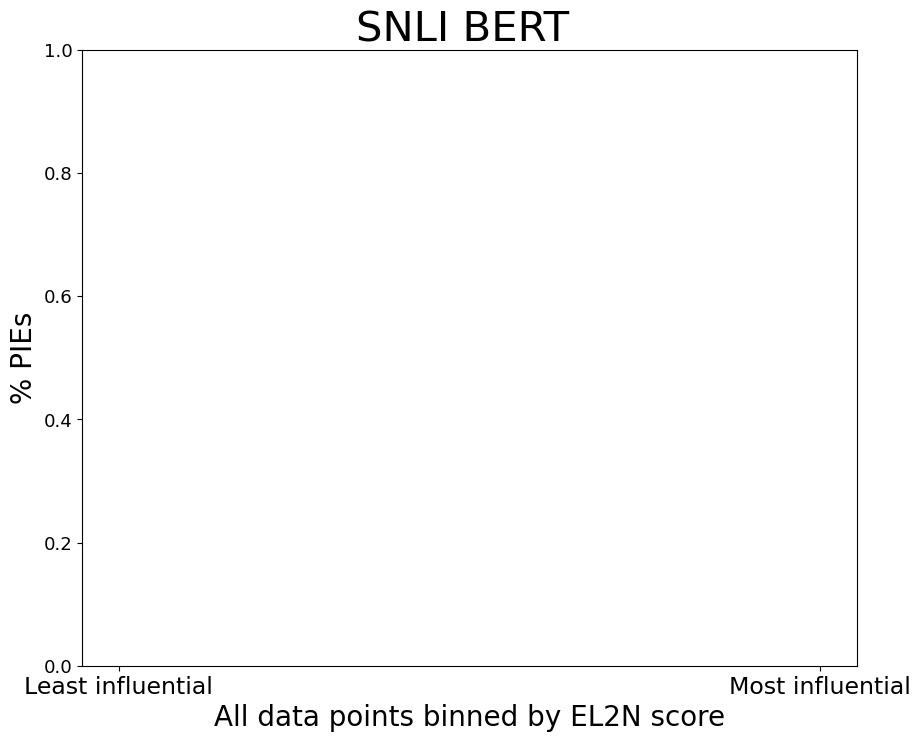

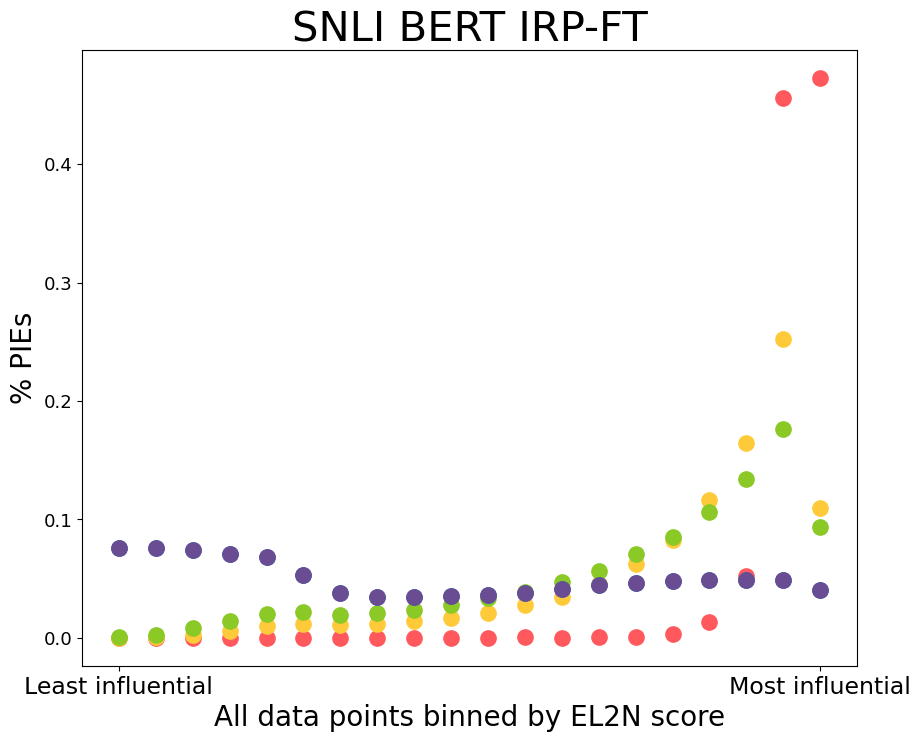

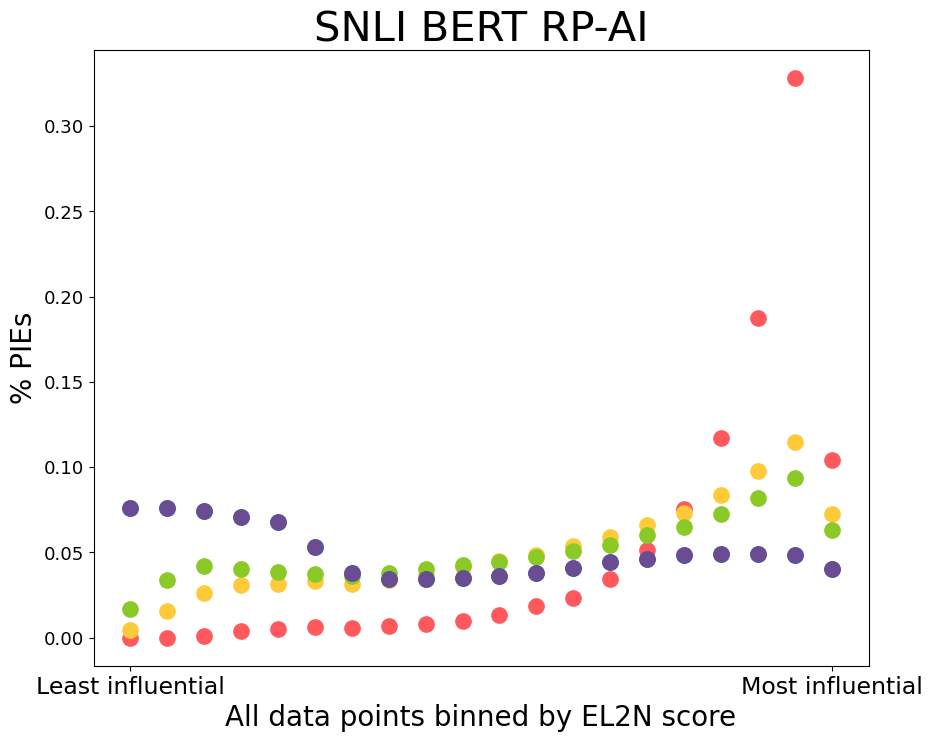

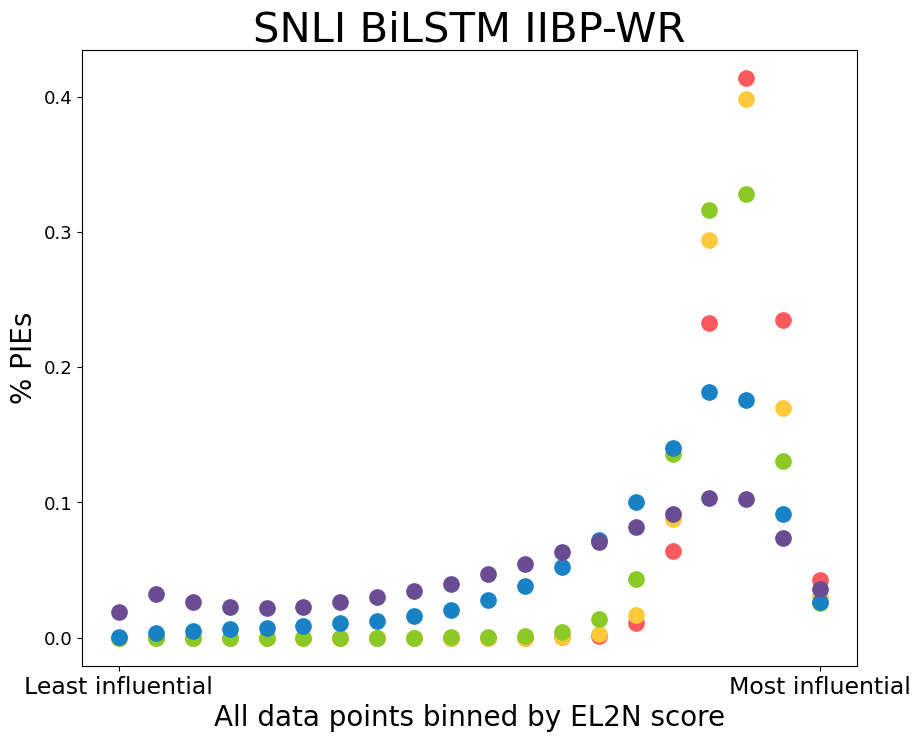

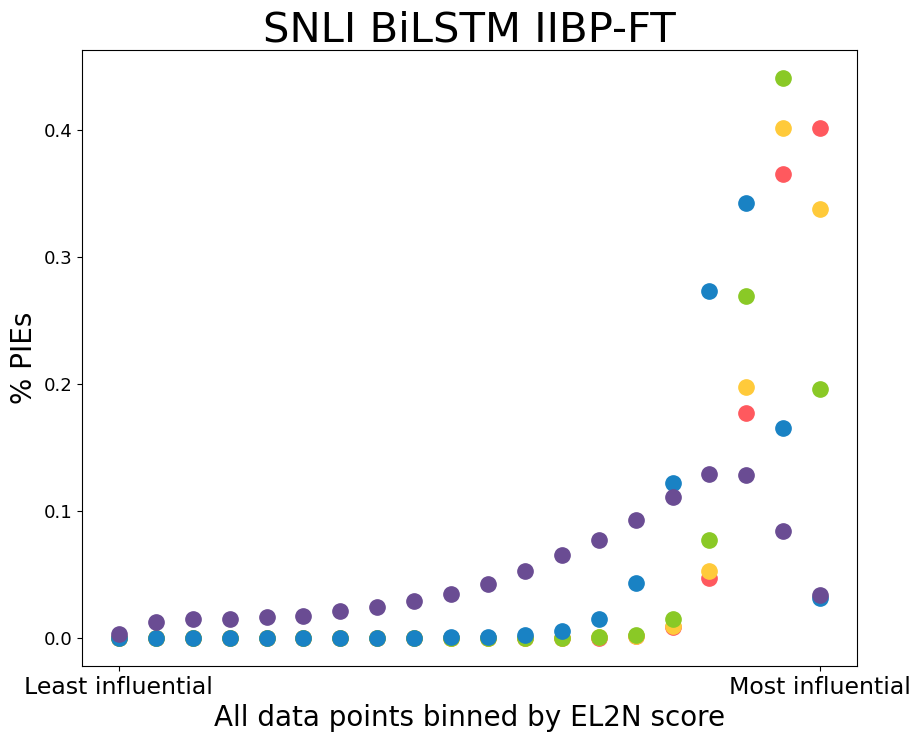

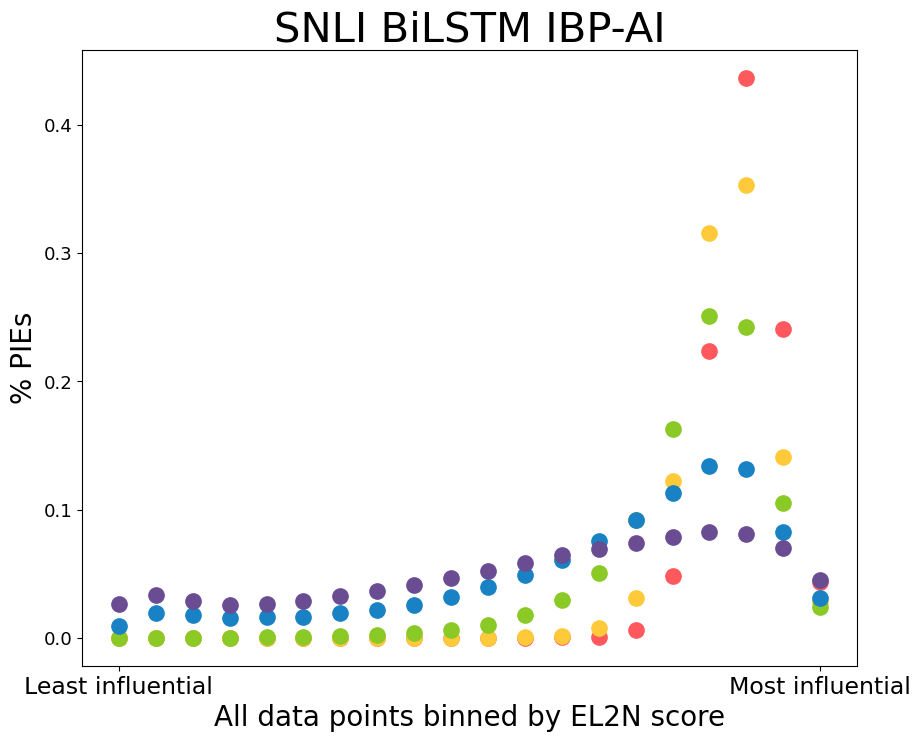

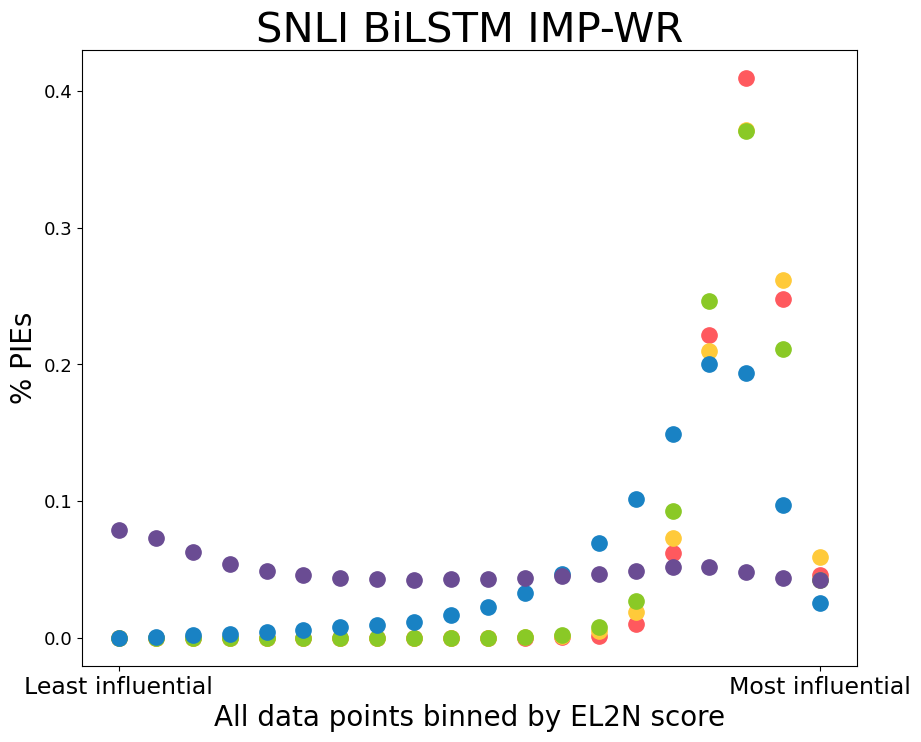

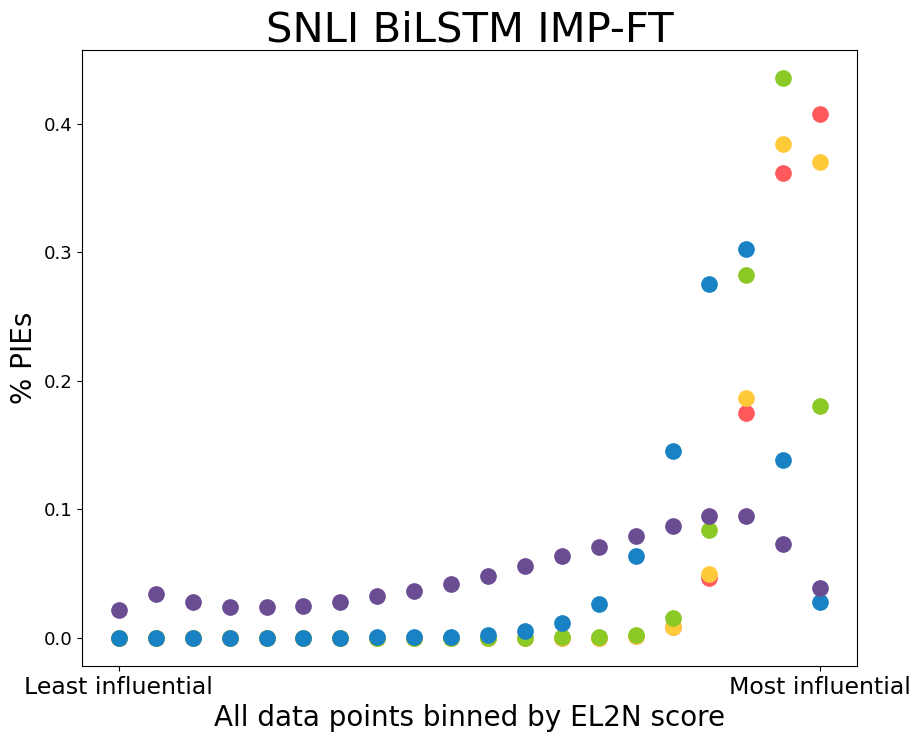

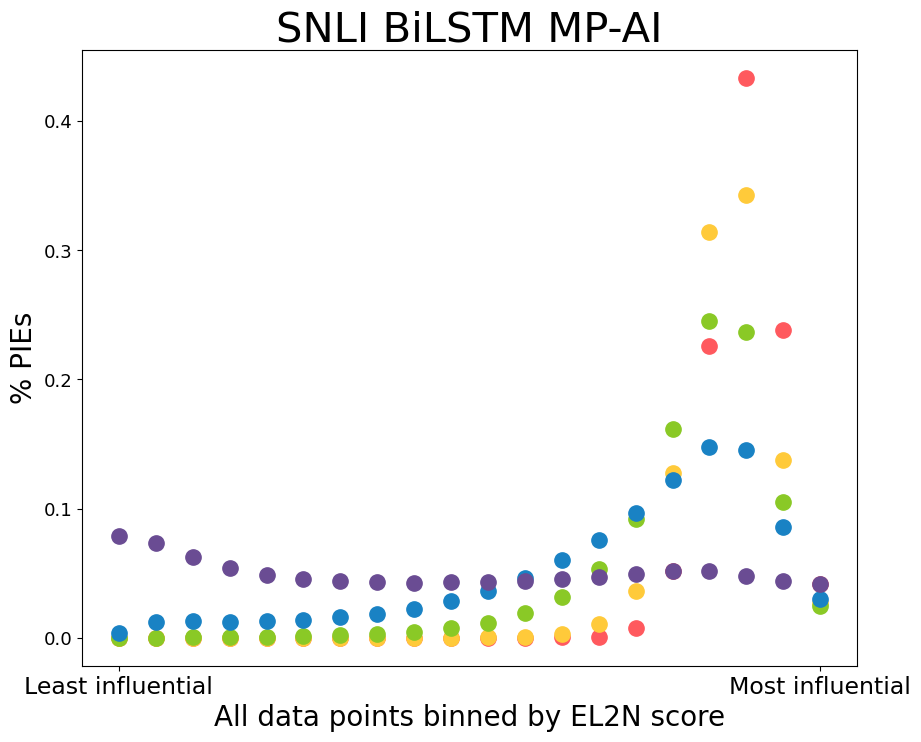

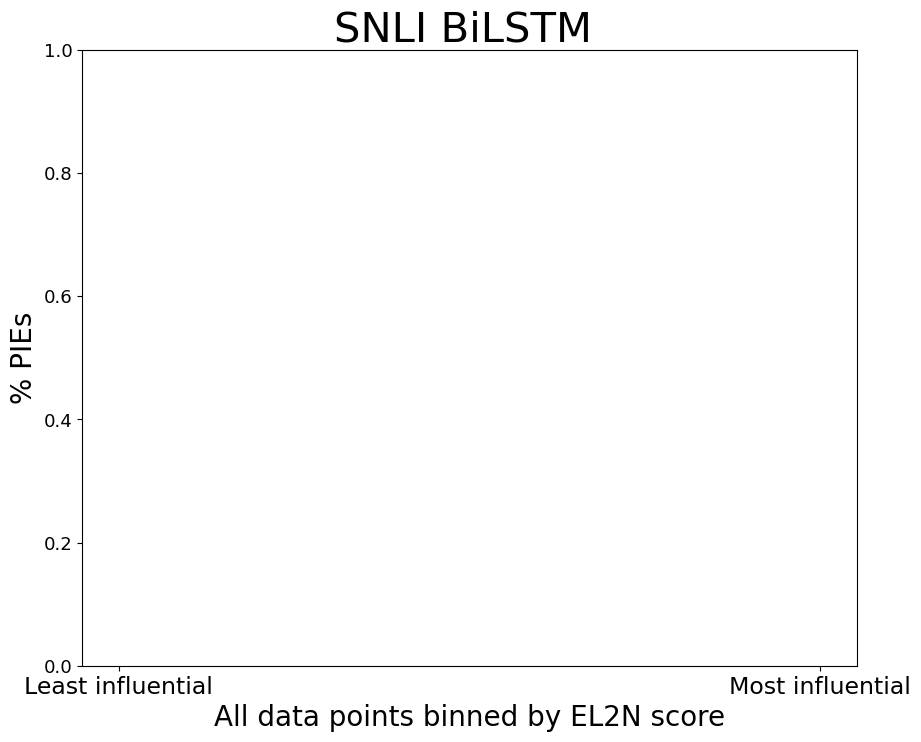

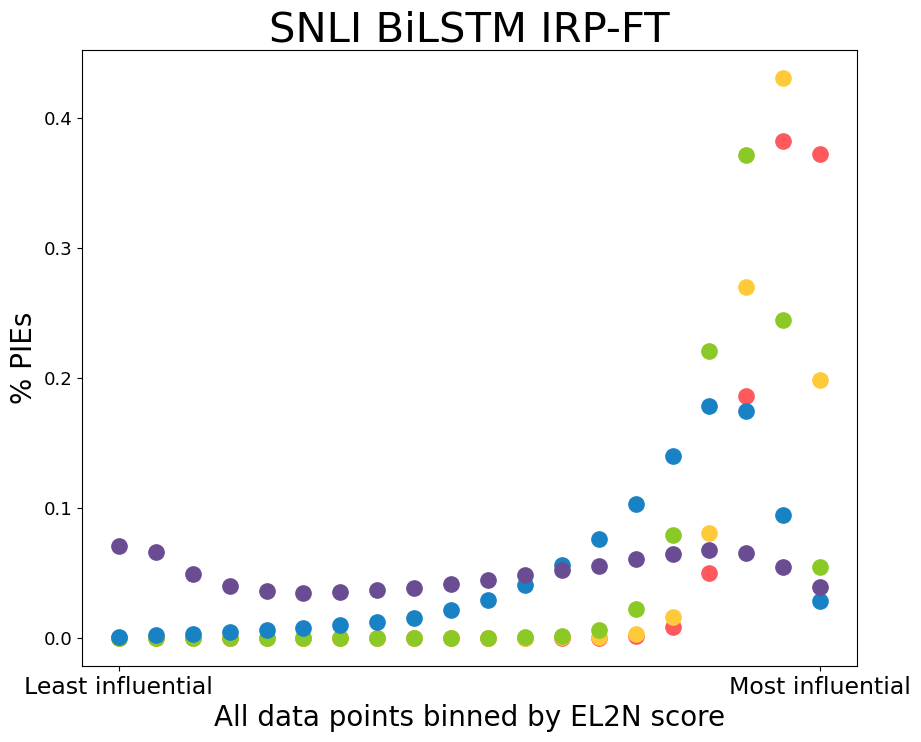

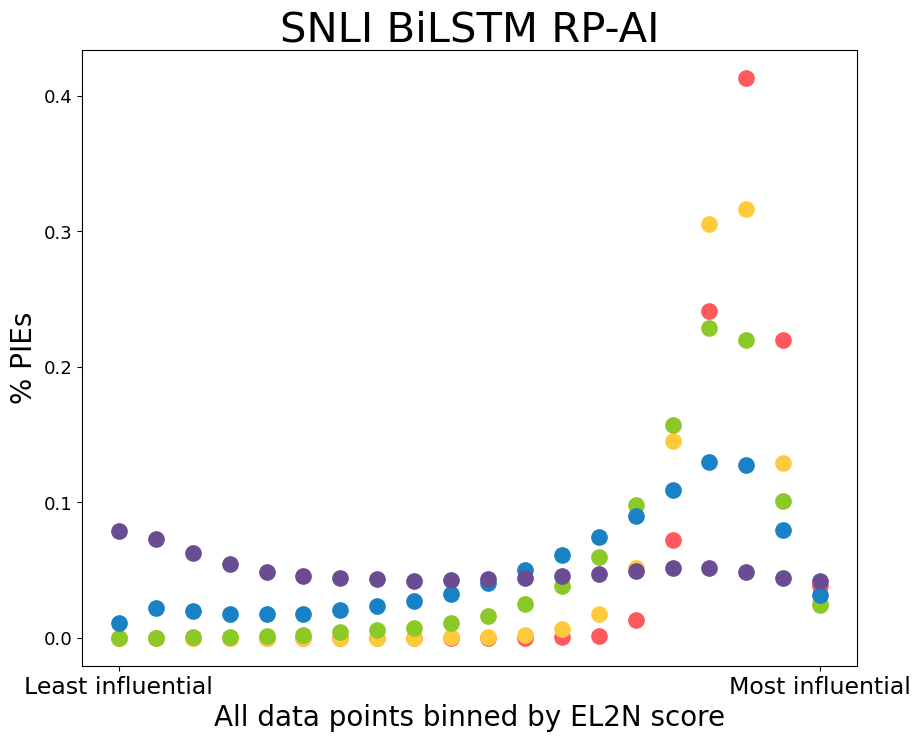

In [1]:
import matplotlib.pyplot as plt
import json
import os
 
width = 10
height = 8
# Opening JSON file
with open("partial_results_PIES_influential_examples.json", 'r') as openfile:
 
    # Reading from json file
    json_object = json.load(openfile)
 
print(json_object)

for to_print in json_object:
    

    plt.figure(figsize=(width, height))
    plt.xlim(0, 21)
    plt.yticks(fontsize=13)
    plt.xticks([1, 20],["Least influential", "Most influential"], fontsize=17)
    plt.xlabel('All data points binned by EL2N score', fontsize=20)
    plt.ylabel('% PIEs', fontsize=20)
    #plt.grid()

    title = to_print["title"]
    if "WR" not in title and "AI" not in title:
        title = title.replace("IMP", "IMP-FT")
        title = title.replace("IBP", "IBP-FT")
        title = title.replace("IRP", "IRP-FT")

    plt.title(title, fontsize=30)
    x = [i+1 for i in range(20)]



    

    for k in to_print['to_plot']:

        if "NoPruning" not in to_print["title"] and "random-WRs" not in to_print["title"]:# and k not in ["50", "70", "90"]:
            plt.plot(x, to_print['to_plot'][k][0], '.', color=to_print['to_plot'][k][1], markersize=22) 

    if "IMDB" in to_print["filename"] and "BERT" in to_print["filename"]:
        plt.legend(['20%', '50%', '70%', '90%', '99%'], loc='upper left', prop={'size': 25})

    dir = "/".join(to_print["filename"].split("/")[:-1])
    
    if not os.path.isdir(dir):
        os.makedirs(dir)
    plt.savefig(to_print["filename"], dpi=400, transparent=True, pad_inches=0.02)
